In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import utils # stuff I've written for this project

import os, sys, datetime, glob, re
import os.path as op

import fnmatch

import logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
consoleHandler = logging.StreamHandler()
consoleHandler.setLevel(logging.DEBUG)
fileHandler = logging.FileHandler('sub-LL_analysis.log')
fileHandler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
consoleHandler.setFormatter(formatter)
fileHandler.setFormatter(formatter)
logger.addHandler(consoleHandler)
logger.addHandler(fileHandler)
logger.setLevel(logging.DEBUG)

import numpy as np
np.set_printoptions(precision=4)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import shutil

import nibabel as nib

import nilearn
from nilearn.masking import apply_mask
from nilearn.plotting import plot_img, plot_epi, plot_roi, plot_stat_map, view_img, plot_anat
from nilearn.image import load_img, math_img, resample_to_img, new_img_like
from nilearn.input_data import NiftiMasker

import nitime
import nitime.fmri.io as nfio
import nitime.timeseries as ts
import nitime.analysis as nta
import nitime.utils as ntu
import nitime.viz as ntv
import nitime.algorithms as ntalg

import scipy

from bids import BIDSLayout

In [3]:
%matplotlib inline

In [4]:
print(' numpy: ', np.__version__, '\n',
      'nibabel: ', nib.__version__, '\n',
      'nilearn: ', nilearn.__version__, '\n',
      'nitime: ', nitime.__version__, '\n',
      'scipy: ', scipy.__version__,)

 numpy:  1.20.0 
 nibabel:  3.2.1 
 nilearn:  0.7.0 
 nitime:  0.9 
 scipy:  1.6.0


## Initial definitions (before any preprocessing)

 * conn_ref_vol should be the first volume of the first run of the connectivity task
 * hemi_ref_vol should be the first volume of the first run of the hemifield task IN THE SAME SESSION
   * changed for this subject to have more explicit names for hemifield tasks from each session
     * lgn_hemi_ref_vol is the hemifield runs from the lgn session
 * lgn_ref_vol should be the reference volume of the LGN scans, a separate session (20191221 in this case)

In [5]:
sub = "LL"
#ses_lgn = "20210511" # LGN MPLocalizer (and hemifield), single-band limited FOV
ses_lgn = "20211201" # LGN MPLocalizer (and hemifield), MB3 wholebrain seq
ses_prf = "20210810"
ses_conn = "20210909"

raw_data_dir = os.path.abspath("/Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/")
raw_layout = BIDSLayout(raw_data_dir, validate=False, derivatives=False)
derivs_dir = os.path.abspath("/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams")
# comment this out if freesurfer not done yet
# Dev's freesurfer dir
freesurfer_dir = f"{derivs_dir}/freesurfer" 

out_dir = os.path.abspath(f"{derivs_dir}/sub-{sub}")
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

conn_ref_vol_name = f"sub-{sub}_ses-{ses_conn}_task-conn_refvol"
conn_ref_vol_path = os.path.abspath(f"{out_dir}/{conn_ref_vol_name}.nii.gz")
conn_mask_file = os.path.join(out_dir, f"sub-{sub}_ses-{ses_conn}_task-conn_mask.nii.gz")
lgn_hemi_ref_vol_name = f"sub-{sub}_ses-{ses_lgn}_task-hemi_refvol"
lgn_hemi_ref_vol_path = os.path.abspath(f"{out_dir}/{lgn_hemi_ref_vol_name}.nii.gz")
lgn_hemi_mask_file = os.path.join(out_dir, f"sub-{sub}_ses-{ses_lgn}_task-hemi_mask.nii.gz")
prf_ref_vol_name = f"sub-{sub}_ses-{ses_prf}_task-prf_refvol.nii.gz"
prf_ref_vol_path = os.path.abspath(f"{out_dir}/{prf_ref_vol_name}")
lgn_hemi_ref_vol_img = load_img(lgn_hemi_ref_vol_path) # will fail if refvol not created yet
prf_ref_vol_img = load_img(prf_ref_vol_path) # will fail if refvol not created yet
conn_ref_vol_img = load_img(conn_ref_vol_path) # will fail if refvol not created yet

//anaconda/envs/streams/lib/python3.7/site-packages/bids/layout/models.py:152: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  FutureWarning)


## Begin Preprocessing

### Make ref_vol from first dicom

In [6]:
### need to escape spaces!
### Do for each sequence
#first_dicom_hemi = "/Users/smerdis/data/LGN/Ll_Lgn_20210511/Silver_Arjun\ -\ 1/sb_bold_1p75mmISO_PSN_3/IM-0003-0001.dcm"

# use first dicom of 3rd epi (second mp) due to motion artifacts in the first two runs
first_dicom_lgnmb3 = "/Users/smerdis/data/LGN/Ll_Lgn_Mb3_20211201/Silver_Arjun\ -\ 1/mb_bold_mb3_1p75mm_PSN_1p75slice_12/IM-0012-0001.dcm"
#first_dicom_prf = "/Users/smerdis/data/LGN/Nb_20191221/Silver_Arjun\ -\ 1/sb_bold_1p75mmISO_PSN_7/IM-0007-0001.dcm"
#first_dicom_conn = "/Users/smerdis/data/LGN/Ll_Mpconn_20210909/Silver_Arjun\ -\ 1/mb_bold_mb3_1p75mm_PSN_1p75slice_4/IM-0004-0001.dcm"


In [7]:
!ls {first_dicom_lgnmb3}
#!ls {first_dicom_conn}
#!ls {first_dicom_hemi}
#!ls {first_dicom_prf}

/Users/smerdis/data/LGN/Ll_Lgn_Mb3_20211201/Silver_Arjun - 1/mb_bold_mb3_1p75mm_PSN_1p75slice_12/IM-0012-0001.dcm


In [10]:
# dcm2niix_cmd = f"dcm2niix -v 2 -s y -f {conn_ref_vol_name} -z y -o {out_dir} {first_dicom_conn}"
# dcm2niix_cmd = f"dcm2niix -v 2 -s y -f {prf_ref_vol_name} -z y -o {out_dir} {first_dicom_prf}"
#dcm2niix_cmd = f"dcm2niix -v 2 -s y -f {lgn_hemi_ref_vol_name} -z y -o {out_dir} {first_dicom_hemi}"

# lgn mb3
dcm2niix_cmd = f"dcm2niix -v 2 -s y -f {lgn_hemi_ref_vol_name} -z y -o {out_dir} {first_dicom_lgnmb3}"

print(dcm2niix_cmd)
os.system(dcm2niix_cmd)

dcm2niix -v 2 -s y -f sub-LL_ses-20211201_task-hemi_refvol -z y -o /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL /Users/smerdis/data/LGN/Ll_Lgn_Mb3_20211201/Silver_Arjun\ -\ 1/mb_bold_mb3_1p75mm_PSN_1p75slice_12/IM-0012-0001.dcm


0

In [11]:
# dcm2niix_cmd = f"dcm2niix -v 2 -s y -f {lgn_hemi_ref_vol_name} -z y -o {out_dir} {first_dicom_hemi}"
# print(dcm2niix_cmd)

In [12]:
!ls -t {out_dir}

sub-LL_ses-20211201_task-hemi_refvol.nii.gz
sub-LL_ses-20211201_task-hemi_refvol.json
ses-20211201
sub-LL_ses-20210909_task-conn_desc-bet_refvol.nii.gz
sub-LL_ses-20210511_desc-RLGN_space-T1w_roi.nii.gz
sub-LL_ses-20210511_desc-LLGN_space-T1w_roi.nii.gz
sub-LL_from-lgn_to-prf_mode-image_xfm.txt
sub-LL_from-T1w_to-prf_mode-image_xfm.txt
sub-LL_from-prf_to-T1w_mode-image_xfm.txt
sub-LL_from-lgn_to-T1w_mode-image_xfm.txt
sub-LL_from-conn_to-prf_mode-image_xfm.txt
sub-LL_ses-20210810_task-prf_refvol_space-conn.nii.gz
sub-LL_from-prf_to-conn_mode-image_xfm.txt
sub-LL_from-conn_to-lgn_mode-image_xfm.txt
sub-LL_ses-20210511_task-lgn_refvol_space-conn.nii.gz
sub-LL_from-lgn_to-conn_mode-image_xfm.txt
sub-LL_from-T1w_to-conn_mode-image_xfm.txt
sub-LL_ses-20210909_task-conn_refvol_space-T1w.nii.gz
sub-LL_from-conn_to-T1w_mode-image_xfm.txt
sub-LL_ses-20210909_task-conn_run-09_space-conn_phase_map.nii
sub-LL_ses-20210909_task-conn_run-09_space-conn_coherence_map.nii
sub-LL_ses-20210909_task-conn_

### Define refence volume

In [ ]:
#conn_ref_vol_img = load_img(conn_ref_vol_path)
# lgn_hemi_ref_vol_img = load_img(lgn_hemi_ref_vol_path)
# because hemifield and mp use the same sequence and are collected in the same session, just use the same refvol
# mp_ref_vol_img = lgn_hemi_ref_vol_img
#prf_ref_vol_img = load_img(prf_ref_vol_path)

In [6]:
raw_bolds_conn = sorted([f for f in raw_layout.get(subject=sub, session=ses_conn, task='conn', suffix='bold',
            extension=['nii.gz'], return_type='file')])
raw_bolds_hemi = sorted([f for f in raw_layout.get(subject=sub, session=ses_lgn, task='hemi', suffix='bold',
            extension=['nii.gz'], return_type='file')])
raw_bolds_mp = sorted([f for f in raw_layout.get(subject=sub, session=ses_lgn, task='mp', suffix='bold',
            extension=['nii.gz'], return_type='file')])
print('\n'.join(raw_bolds_mp))

/Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/ses-20211201/func/sub-LL_ses-20211201_task-mp_run-01_bold.nii.gz
/Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/ses-20211201/func/sub-LL_ses-20211201_task-mp_run-02_bold.nii.gz
/Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/ses-20211201/func/sub-LL_ses-20211201_task-mp_run-03_bold.nii.gz
/Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/ses-20211201/func/sub-LL_ses-20211201_task-mp_run-04_bold.nii.gz
/Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/ses-20211201/func/sub-LL_ses-20211201_task-mp_run-05_bold.nii.gz
/Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/ses-20211201/func/sub-LL_ses-20211201_task-mp_run-06_bold.nii.gz
/Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/ses-20211201/func/sub-LL_ses-20211201_task-mp_run-07_bold.nii.gz
/Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/ses-20211201/func/sub-LL_ses-20211201_task-mp_run-08_bold.nii.gz
/Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/ses-20211201/func/sub-LL_ses-20211201_task-mp_ru

In [14]:
!ls {lgn_hemi_ref_vol_path}

/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_task-hemi_refvol.nii.gz


In [15]:
print(raw_bolds_hemi, raw_bolds_conn)

['/Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/backup-ses-20211201-firstattempt/func/sub-LL_ses-20211201_task-hemi_run-01_bold.nii.gz', '/Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/backup-ses-20211201-firstattempt/func/sub-LL_ses-20211201_task-hemi_run-02_bold.nii.gz', '/Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/backup-ses-20211201_fullbids/sub-LL/ses-20211201/func/sub-LL_ses-20211201_task-hemi_run-01_bold.nii.gz', '/Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/backup-ses-20211201_fullbids/sub-LL/ses-20211201/func/sub-LL_ses-20211201_task-hemi_run-02_bold.nii.gz', '/Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/ses-20211201/func/sub-LL_ses-20211201_task-hemi_run-01_bold.nii.gz', '/Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/ses-20211201/func/sub-LL_ses-20211201_task-hemi_run-02_bold.nii.gz'] ['/Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/ses-20210909/func/sub-LL_ses-20210909_task-conn_run-01_bold.nii.gz', '/Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/ses-2021090

### Brain extract the ref_vols to see if this helps estimate transforms

In [10]:
#!ls {conn_ref_vol_path}

/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210909_task-conn_refvol.nii.gz


In [6]:
conn_bet_refvol_stub = utils.change_bids_description(conn_ref_vol_path, 'desc-bet', 'desc')
conn_bet_refvol_path = f"{out_dir}/{conn_bet_refvol_stub}"

# bet_cmd = f"bet {conn_ref_vol_path} {conn_bet_refvol_path} -R"
# print(bet_cmd)
# os.system(bet_cmd)

lgn_bet_refvol_stub = utils.change_bids_description(lgn_hemi_ref_vol_path, 'desc-bet', 'desc')
lgn_bet_refvol_path = f"{out_dir}/{lgn_bet_refvol_stub}"

# bet_cmd = f"bet {lgn_hemi_ref_vol_path} {lgn_bet_refvol_path} -R"
# print(bet_cmd)
# os.system(bet_cmd)

### mcflirt the bold files using ref_vol as the reference image, save them

In [16]:
print("\n".join(raw_bolds_mp))

/Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/ses-20211201/func/sub-LL_ses-20211201_task-mp_run-01_bold.nii.gz
/Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/ses-20211201/func/sub-LL_ses-20211201_task-mp_run-02_bold.nii.gz
/Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/ses-20211201/func/sub-LL_ses-20211201_task-mp_run-03_bold.nii.gz
/Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/ses-20211201/func/sub-LL_ses-20211201_task-mp_run-04_bold.nii.gz
/Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/ses-20211201/func/sub-LL_ses-20211201_task-mp_run-05_bold.nii.gz
/Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/ses-20211201/func/sub-LL_ses-20211201_task-mp_run-06_bold.nii.gz
/Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/ses-20211201/func/sub-LL_ses-20211201_task-mp_run-07_bold.nii.gz
/Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/ses-20211201/func/sub-LL_ses-20211201_task-mp_run-08_bold.nii.gz
/Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/ses-20211201/func/sub-LL_ses-20211201_task-mp_ru

In [ ]:
# MPConn
for this_epi in raw_bolds_conn:
    align_to = 'refvol' #'refvol' # or 'anat'
    epi_stub_mcf = utils.change_bids_description(this_epi, 'desc-mcflirt')
    epi_stub_bet = utils.change_bids_description(this_epi, 'desc-preproc')
    if not os.path.isdir(os.path.join(out_dir, f"ses-{ses_conn}", "func")):
        os.makedirs(os.path.join(out_dir, f"ses-{ses_conn}", "func"))
    full_outpath = os.path.join(out_dir, f"ses-{ses_conn}", "func", epi_stub_mcf)
    full_outpath_bet = os.path.join(out_dir, f"ses-{ses_conn}", "func", epi_stub_bet)
    if align_to == 'refvol':
        mcflirt_cmd = f"mcflirt -reffile {conn_ref_vol_path} -mats -plots -report -cost mutualinfo -smooth 16 -in {this_epi} -o {full_outpath}"
    elif align_to == 'anat':
        mcflirt_cmd = f"mcflirt -reffile {anat_file} -mats -plots -report -cost mutualinfo -smooth 16 -in {this_epi} -o {full_outpath}_anatalign"
    print(mcflirt_cmd)
    #os.system(mcflirt_cmd)
    bet_cmd = f"bet {full_outpath} {full_outpath_bet} -R"
    print(bet_cmd, os.system(bet_cmd))

In [17]:
# LGN session hemifield
for this_epi in raw_bolds_hemi:
    align_to = 'refvol' #'refvol' # or 'anat'
    epi_stub_mcf = utils.change_bids_description(this_epi, 'desc-mcflirt')   
    if not os.path.isdir(os.path.join(out_dir, f"ses-{ses_lgn}", "func")):
        os.makedirs(os.path.join(out_dir, f"ses-{ses_lgn}", "func"))
    full_outpath = os.path.join(out_dir, f"ses-{ses_lgn}", "func", epi_stub_mcf)
    if align_to == 'refvol':
        mcflirt_cmd = f"mcflirt -reffile {lgn_hemi_ref_vol_path} -mats -plots -report -cost mutualinfo -smooth 16 -in {this_epi} -o {full_outpath}"
    elif align_to == 'anat':
        mcflirt_cmd = f"mcflirt -reffile {anat_file} -mats -plots -report -cost mutualinfo -smooth 16 -in {this_epi} -o {full_outpath}_anatalign"
    print(mcflirt_cmd)
    os.system(mcflirt_cmd)

mcflirt -reffile /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_task-hemi_refvol.nii.gz -mats -plots -report -cost mutualinfo -smooth 16 -in /Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/backup-ses-20211201-firstattempt/func/sub-LL_ses-20211201_task-hemi_run-01_bold.nii.gz -o /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/ses-20211201/func/sub-LL_ses-20211201_task-hemi_run-01_desc-mcflirt_bold
mcflirt -reffile /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_task-hemi_refvol.nii.gz -mats -plots -report -cost mutualinfo -smooth 16 -in /Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/backup-ses-20211201-firstattempt/func/sub-LL_ses-20211201_task-hemi_run-02_bold.nii.gz -o /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/ses-20211201/func/sub-LL_ses-20211201_task-hemi_run-02_desc-mcflirt_bold
mcflirt -reffile /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/

In [18]:
# LGN session MPLocalizer
for this_epi in raw_bolds_mp:
    align_to = 'refvol' #'refvol' # or 'anat'
    epi_stub_mcf = utils.change_bids_description(this_epi, 'desc-mcflirt')   
    if not os.path.isdir(os.path.join(out_dir, f"ses-{ses_lgn}", "func")):
        os.makedirs(os.path.join(out_dir, f"ses-{ses_lgn}", "func"))
    full_outpath = os.path.join(out_dir, f"ses-{ses_lgn}", "func", epi_stub_mcf)
    if align_to == 'refvol':
        mcflirt_cmd = f"mcflirt -reffile {lgn_hemi_ref_vol_path} -mats -plots -report -cost mutualinfo -smooth 16 -in {this_epi} -o {full_outpath}"
    elif align_to == 'anat':
        mcflirt_cmd = f"mcflirt -reffile {anat_file} -mats -plots -report -cost mutualinfo -smooth 16 -in {this_epi} -o {full_outpath}_anatalign"
    print(mcflirt_cmd)
    os.system(mcflirt_cmd)

mcflirt -reffile /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_task-hemi_refvol.nii.gz -mats -plots -report -cost mutualinfo -smooth 16 -in /Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/ses-20211201/func/sub-LL_ses-20211201_task-mp_run-01_bold.nii.gz -o /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/ses-20211201/func/sub-LL_ses-20211201_task-mp_run-01_desc-mcflirt_bold
mcflirt -reffile /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_task-hemi_refvol.nii.gz -mats -plots -report -cost mutualinfo -smooth 16 -in /Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/ses-20211201/func/sub-LL_ses-20211201_task-mp_run-02_bold.nii.gz -o /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/ses-20211201/func/sub-LL_ses-20211201_task-mp_run-02_desc-mcflirt_bold
mcflirt -reffile /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_task-hemi_refvol.nii.

In [ ]:
!ls /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/ses-20210909/func/sub-LL_ses-20210909_task-conn_run-02_desc-mcflirt_bold.nii.gz

### Make brainmask if it doesn't exist already

In [ ]:
conn_ref_bold_run = raw_bolds_conn[0]
conn_TR = raw_layout.get_metadata(conn_ref_bold_run)['RepetitionTime'] # instead of get_tr()

In [ ]:
conn_TR

In [ ]:
!ls {conn_mask_file}

In [ ]:
conn_masker = NiftiMasker(detrend=False, standardize=False, mask_strategy="epi", t_r=conn_TR)
conn_masker.fit(conn_ref_bold_run)
conn_masker.mask_img_.to_filename(conn_mask_file)
conn_mask_img = conn_masker.mask_img_
print(conn_mask_file, conn_mask_img.shape)

In [19]:
!ls {lgn_hemi_mask_file}

ls: /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_task-hemi_mask.nii.gz: No such file or directory


In [ ]:
!ls {hemi_ref_bold_run}

In [27]:
raw_layout.get_metadata(path=hemi_ref_bold_run)

{'AcquisitionMatrixPE': 120,
 'AcquisitionNumber': 1,
 'AcquisitionTime': '12:33:38.552500',
 'BandwidthPerPixelPhaseEncode': 12.077,
 'BaseResolution': 120,
 'CoilString': 'C:HEA;HEP',
 'ConversionSoftware': 'dcm2niix',
 'ConversionSoftwareVersion': 'v1.0.20181114  Clang4.0.1',
 'Dcm2bidsVersion': '2.1.4',
 'DerivedVendorReportedEchoSpacing': 0.000690017,
 'DeviceSerialNumber': '35328',
 'DwellTime': 2.4e-06,
 'EchoTime': 0.0328,
 'EffectiveEchoSpacing': 0.000690017,
 'FlipAngle': 45,
 'ImageComments': 'Unaliased_MB3_PE3',
 'ImageOrientationPatientDICOM': [1, 0, 0, 0, 0.936672, -0.350207],
 'ImageType': ['ORIGINAL', 'PRIMARY', 'M', 'MB', 'ND', 'MOSAIC'],
 'ImagingFrequency': 123.228,
 'InPlanePhaseEncodingDirectionDICOM': 'COL',
 'InstitutionAddress': 'Street_StreetNo_Berkeley_District_US_ZIP',
 'InstitutionName': 'UC_Berkeley',
 'InstitutionalDepartmentName': 'Department',
 'MRAcquisitionType': '2D',
 'MagneticFieldStrength': 3,
 'Manufacturer': 'Siemens',
 'ManufacturersModelName': 

In [20]:
hemi_ref_bold_run = raw_bolds_mp[1] # choosing this one because hemi-01 and mp-01 had motion? artifacts
print(hemi_ref_bold_run)
hemi_TR = raw_layout.get_metadata(path=hemi_ref_bold_run)['RepetitionTime']
hemi_masker = NiftiMasker(detrend=False, standardize=False, mask_strategy="epi", t_r=hemi_TR)
hemi_masker.fit(hemi_ref_bold_run)
hemi_masker.mask_img_.to_filename(lgn_hemi_mask_file)
hemi_mask_img = hemi_masker.mask_img_
print(lgn_hemi_mask_file, hemi_mask_img.shape)

/Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/ses-20211201/func/sub-LL_ses-20211201_task-mp_run-02_bold.nii.gz
/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_task-hemi_mask.nii.gz (120, 120, 69)


### Move event and json files

In [34]:
!sed '$d' /Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/ses-20211201/func/sub-ll_ses-20211201_task-mp_run-04_events_1305.tsv

onset	duration	trial_type
0.00	18	M
20.25	18	blank
40.50	18	M
60.75	18	P
81.00	18	M
101.25	18	P
121.50	18	M
141.75	18	P
162.00	18	M
182.25	18	P
202.50	18	blank
222.75	18	P
243.00	18	M
263.25	18	blank


In [29]:
!ghead -n -1 /Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/ses-20211201/func/sub-ll_ses-20211201_task-mp_run-08_events_1328.tsv

/bin/bash: ghead: command not found


In [32]:
f"sub-{sub}".lower()

'sub-ll'

In [36]:
events_glob = f"{raw_data_dir}/ses-{ses_lgn}/func/*events*.tsv"
for ef in glob.glob(events_glob):
    parts = ef.split('_')
    for i, part in enumerate(parts):
        #print(i, part)
        if f"sub-{sub}".lower() in part:
            parts[i] = part.replace(f"sub-{sub}".lower(), f"sub-{sub}")
    [lastpart, ext] = parts[-1].split('.')
    print(parts, lastpart, ext, lastpart.isnumeric())
    if lastpart.isnumeric(): # the event file has a suffix indicating the time it was written, remove it
        parts[-2] = parts[-2] + '.' + ext
        out_fn = '_'.join(parts[:-1])
        #cmd = f"cp {ef} {out_fn}" # normally we just copy the file, but for LL ses-20211201 we want to remove hte last block
        cmd = f"sed '$d' {ef} > {out_fn}" # so this copies all but the last line to the new fn
        print(cmd)
        os.system(cmd)
task_json_glob = f"{raw_data_dir}/ses-{ses_lgn}/func/*task*json"
print("\n".join(glob.glob(task_json_glob)))

['/Users/smerdis/data/LGN/BIDS/LL', 'combined/sub-LL/ses-20211201/func/sub-LL', 'ses-20211201', 'task-mp', 'run-04', 'events', '1305.tsv'] 1305 tsv True
sed '$d' /Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/ses-20211201/func/sub-ll_ses-20211201_task-mp_run-04_events_1305.tsv > /Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/ses-20211201/func/sub-LL_ses-20211201_task-mp_run-04_events.tsv
['/Users/smerdis/data/LGN/BIDS/LL', 'combined/sub-LL/ses-20211201/func/sub-LL', 'ses-20211201', 'task-mp', 'run-09', 'events', '1334.tsv'] 1334 tsv True
sed '$d' /Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/ses-20211201/func/sub-ll_ses-20211201_task-mp_run-09_events_1334.tsv > /Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/ses-20211201/func/sub-LL_ses-20211201_task-mp_run-09_events.tsv
['/Users/smerdis/data/LGN/BIDS/LL', 'combined/sub-LL/ses-20211201/func/sub-LL', 'ses-20211201', 'task-mp', 'run-01', 'events', '1244.tsv'] 1244 tsv True
sed '$d' /Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/ses-

## Define paths after preprocessing is complete

In [8]:
preproc_layout = BIDSLayout(out_dir, validate=False)
lgn_rois = [f for f in preproc_layout.get(subject=sub, extension=['.nii.gz'], suffix='roi',
        return_type='file', space='lgn', session=ses_lgn)
        if fnmatch.fnmatch(f, "*desc-[LR]LGN*")]
big_rois = [f for f in preproc_layout.get(subject=sub, extension=['.nii.gz'], suffix='roi',
        return_type='file', space='lgn', session=ses_lgn)
        if fnmatch.fnmatch(f, "*desc-[LR]LGN_*")]
cortical_rois = [f for f in preproc_layout.get(subject=sub, space='conn',
                extension=['.nii.gz'], suffix='roi', return_type='file')
        if fnmatch.fnmatch(f, "*desc-[LR]*") and "LGN" not in op.basename(f)]
lgn_ref_vol = lgn_hemi_ref_vol_path # using hemifield ref vol as refvol for all lgn scans (ses 20210505)
lgn_ref_img = load_img(lgn_ref_vol)
lgn_mask_file = lgn_hemi_mask_file # and hemifield mask as mask for all lgn scans (ses 20210505)

# using the T1 file from the freesurfer reconstruction used by Dev to get pRFs, converted to Nifti lower down in this notebook
anat_file = f"{out_dir}/sub-{sub}_desc-freesurferbrain_space-T1w_T1w.nii.gz"
#anat_file = raw_layout.get(subject=sub, session='20210511', extension=['nii.gz'], suffix="T1w", return_type='file')[0]
anat_img = load_img(anat_file)
freesurfer_anat_mgz = f"{freesurfer_dir}/{sub}/mri/brain.mgz" # the mgz file the anat_file was made from
wmseg_nii = f"{out_dir}/sub-{sub}_desc-freesurferwmseg-space-T1w_map.nii.gz"

print("LGN rois (including M/P):", '\n'.join(lgn_rois),
      "LGN rois (LGN only):", '\n'.join(big_rois),
      "Cortical rois: ", '\n'.join(cortical_rois),
      "Reference BOLD volume for connectivity:", conn_ref_vol_path,
      "Brainmask for connectivity", conn_mask_file,
      "LGN session refvol: ", lgn_ref_vol,
      "LGN session brainmask: ", lgn_mask_file,
      "anat file: ", anat_file, sep="\n")

LGN rois (including M/P):
/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-LLGN_space-lgn_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-LLGNM80_space-lgn_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-LLGNP80_space-lgn_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-RLGN_space-lgn_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-RLGNM80_space-lgn_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-RLGNP80_space-lgn_roi.nii.gz
LGN rois (LGN only):
/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-LLGN_space-lgn_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-RLGN_space-lgn_

In [9]:
print(f"fsleyes {anat_file} {lgn_ref_vol} {prf_ref_vol_path} {conn_ref_vol_path}")

fsleyes /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_desc-freesurferbrain_space-T1w_T1w.nii.gz /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_task-hemi_refvol.nii.gz /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210810_task-prf_refvol.nii.gz /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210909_task-conn_refvol.nii.gz


## Registration and Resampling

In [10]:
fslmaths_roi_threshold = 0.5

conn_to_t1_xfm_path = f"{out_dir}/sub-{sub}_from-conn_to-T1w_mode-image_xfm.txt"
t1_to_conn_xfm_path = f"{out_dir}/sub-{sub}_from-T1w_to-conn_mode-image_xfm.txt"

lgn_to_conn_xfm_path = f"{out_dir}/sub-{sub}_from-lgn_to-conn_mode-image_xfm.txt"
conn_to_lgn_xfm_path = f"{out_dir}/sub-{sub}_from-conn_to-lgn_mode-image_xfm.txt"

lgn_to_t1_xfm_path = f"{out_dir}/sub-{sub}_from-lgn_to-T1w_mode-image_xfm.txt"
t1_to_lgn_xfm_path = f"{out_dir}/sub-{sub}_from-T1w_to-lgn_mode-image_xfm.txt"

prf_to_conn_xfm_path = f"{out_dir}/sub-{sub}_from-prf_to-conn_mode-image_xfm.txt"
conn_to_prf_xfm_path = f"{out_dir}/sub-{sub}_from-conn_to-prf_mode-image_xfm.txt"

prf_to_t1_xfm_path = f"{out_dir}/sub-{sub}_from-prf_to-T1w_mode-image_xfm.txt"
t1_to_prf_xfm_path = f"{out_dir}/sub-{sub}_from-T1w_to-prf_mode-image_xfm.txt"

prf_to_lgn_xfm_path = f"{out_dir}/sub-{sub}_from-prf_to-lgn_mode-image_xfm.txt"
lgn_to_prf_xfm_path = f"{out_dir}/sub-{sub}_from-lgn_to-prf_mode-image_xfm.txt"

# brain extract the T1 for better registration and save it as _brain in out_dir
fn_parts = op.basename(anat_file).split('.')
anat_file_bet_stub = '.'.join([f"{fn_parts[0]}_brain", *fn_parts[1:]])
anat_file_bet = f"{out_dir}/{anat_file_bet_stub}"
# bet_cmd = f"bet {anat_file} {anat_file_bet}"
# print(anat_file, anat_file_bet, bet_cmd, sep="\n")
# print(os.system(bet_cmd))

### epi_reg with freesurfer outputs to do the conn -> T1 registration
 * the matrix it estimates seems the same as that found by flirt, more or less (2021-09-24)
 * UPDATE 2021-12-15 actually epi_reg is better than FLIRT bc the wmseg etc, using epi_reg for all func to anat

In [15]:
utils.epireg_func_to_anat(conn_ref_vol_path, anat_file, anat_file_bet, wmseg_nii,
    f"{out_dir}/{utils.change_bids_description(conn_ref_vol_path, 'space-T1w', 'space-')}",
    conn_to_t1_xfm_path, t1_to_conn_xfm_path)

epi_reg -v --epi=/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210909_task-conn_refvol.nii.gz --t1=/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_desc-freesurferbrain_space-T1w_T1w.nii.gz --t1brain=/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_desc-freesurferbrain_space-T1w_T1w_brain.nii.gz --wmseg=/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_desc-freesurferwmseg-space-T1w_map.nii.gz --out=/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210909_task-conn_space-T1w_refvol 0
convert_xfm -omat /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_from-T1w_to-conn_mode-image_xfm.txt -inverse /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210909_task-conn_space-T1w_refvol.mat && cp /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210909_task-conn_space-T

In [16]:
utils.epireg_func_to_anat(lgn_hemi_ref_vol_path, anat_file, anat_file_bet, wmseg_nii,
    f"{out_dir}/{utils.change_bids_description(hemi_ref_vol_path, 'space-T1w', 'space-')}",
    lgn_to_t1_xfm_path, t1_to_lgn_xfm_path)

NameError: name 'hemi_ref_vol_path' is not defined

#### FLIRT LGN MP localizer to MPConn (MB3), save transform, inverse, and resampled refvol

In [20]:
!ls {lgn_hemi_ref_vol_path}

/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_task-hemi_refvol.nii.gz


In [11]:
flirt_cmd = (f"flirt -in {lgn_hemi_ref_vol_path} -ref {conn_ref_vol_path} -omat {lgn_to_conn_xfm_path} "
    f"-dof 7 -out {out_dir}/sub-{sub}_ses-{ses_lgn}_task-hemi_refvol_space-conn.nii.gz")
logger.debug(flirt_cmd)
logger.debug(os.system(flirt_cmd))

inverse_cmd = f"convert_xfm -omat {conn_to_lgn_xfm_path} -inverse {lgn_to_conn_xfm_path}"
logger.debug(inverse_cmd)
logger.debug(os.system(inverse_cmd))

2021-12-16 21:56:39,040 - __main__ - DEBUG - flirt -in /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_task-hemi_refvol.nii.gz -ref /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210909_task-conn_refvol.nii.gz -omat /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_from-lgn_to-conn_mode-image_xfm.txt -dof 7 -out /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_task-hemi_refvol_space-conn.nii.gz
2021-12-16 21:56:49,922 - __main__ - DEBUG - 0
2021-12-16 21:56:49,946 - __main__ - DEBUG - convert_xfm -omat /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_from-conn_to-lgn_mode-image_xfm.txt -inverse /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_from-lgn_to-conn_mode-image_xfm.txt
2021-12-16 21:56:50,008 - __main__ - DEBUG - 0


#### FLIRT prf <--> conn (MB3)

In [10]:
flirt_cmd = f"flirt -in {prf_ref_vol_path} -ref {conn_ref_vol_path} -omat {prf_to_conn_xfm_path} -out {out_dir}/sub-{sub}_ses-{ses_prf}_task-prf_refvol_space-conn.nii.gz"
print(flirt_cmd, os.system(flirt_cmd))

inverse_cmd = f"convert_xfm -omat {conn_to_prf_xfm_path} -inverse {prf_to_conn_xfm_path}"
print(inverse_cmd, os.system(inverse_cmd))

flirt -in /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210810_task-prf_refvol.nii.gz -ref /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210909_task-conn_refvol.nii.gz -omat /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_from-prf_to-conn_mode-image_xfm.txt -out /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210810_task-prf_refvol_space-conn.nii.gz 0
convert_xfm -omat /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_from-conn_to-prf_mode-image_xfm.txt -inverse /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_from-prf_to-conn_mode-image_xfm.txt 0


#### Concat LGN ---> T1 --> Conn

In [24]:
# convert_xfm -omat AtoC.mat -concat BtoC.mat AtoB.mat
concat_cmd = f"convert_xfm -omat {lgn_to_conn_xfm_path}_concat -concat {t1_to_conn_xfm_path} {lgn_to_t1_xfm_path}"
logger.debug(concat_cmd)
logger.debug(os.system(concat_cmd))

2021-12-16 15:48:38,266 - __main__ - DEBUG - convert_xfm -omat /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_from-lgn_to-conn_mode-image_xfm.txt_concat -concat /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_from-T1w_to-conn_mode-image_xfm.txt /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_from-lgn_to-T1w_mode-image_xfm.txt
2021-12-16 15:48:38,282 - __main__ - DEBUG - 0


#### Concat (pRF ---> MB3 (Conn) ---> T1) and invert this

In [185]:
# concat_cmd = f"convert_xfm -omat {prf_to_t1_xfm_path} -concat {conn_to_t1_xfm_path} {prf_to_conn_xfm_path}"
# print(concat_cmd, os.system(concat_cmd))

# inverse_cmd = f"convert_xfm -omat {t1_to_prf_xfm_path} -inverse {prf_to_t1_xfm_path}"
# print(inverse_cmd, os.system(inverse_cmd))

#### Concat ((LGN ---> MB3 (Conn) ---> T1) ---> pRF)

In [186]:
# # convert_xfm -omat AtoC.mat -concat BtoC.mat AtoB.mat
# concat_cmd = f"convert_xfm -omat {lgn_to_prf_xfm_path} -concat {t1_to_prf_xfm_path} {lgn_to_t1_xfm_path}"
# print(concat_cmd)
# os.system(concat_cmd)

#### FLIRT ROIs from LGN func space to T1 and binarize

In [12]:
for roi in lgn_rois:
    resampled_roi_fn = op.join(out_dir, utils.change_bids_description(roi, 'space-T1w', 'space-'))
    roi_flirt_cmd = (f"flirt -ref {anat_file_bet} -in {roi} -applyxfm -init {lgn_to_t1_xfm_path} "
                     f"-out {resampled_roi_fn} && fslmaths {resampled_roi_fn} -thr {fslmaths_roi_threshold} -bin {resampled_roi_fn}")
    logger.debug(roi_flirt_cmd)
    logger.debug(os.system(roi_flirt_cmd))

2021-12-16 21:57:00,401 - __main__ - DEBUG - flirt -ref /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_desc-freesurferbrain_space-T1w_T1w_brain.nii.gz -in /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-LLGN_space-lgn_roi.nii.gz -applyxfm -init /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_from-lgn_to-T1w_mode-image_xfm.txt -out /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-LLGN_space-T1w_roi && fslmaths /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-LLGN_space-T1w_roi -thr 0.5 -bin /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-LLGN_space-T1w_roi
2021-12-16 21:57:05,173 - __main__ - DEBUG - 0
2021-12-16 21:57:05,177 - __main__ - DEBUG - flirt -ref /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_desc-freesurferbrain_space-

#### FLIRT ROIs from LGN to MPConn space directly (MB3)

In [134]:
big_rois

['/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-LLGN_space-lgn_roi.nii.gz',
 '/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-RLGN_space-lgn_roi.nii.gz']

In [13]:
for roi in lgn_rois:
    resampled_roi_fn = op.join(out_dir, utils.change_bids_description(roi, 'space-conn', 'space-'))
    roi_flirt_cmd = (f"flirt -ref {conn_ref_vol_path} -in {roi} -applyxfm -init {lgn_to_conn_xfm_path} "
                     f"-out {resampled_roi_fn} && fslmaths {resampled_roi_fn} -thr {fslmaths_roi_threshold} -bin {resampled_roi_fn}")
    logger.debug(roi_flirt_cmd)
    logger.debug(os.system(roi_flirt_cmd))

2021-12-16 21:58:10,591 - __main__ - DEBUG - flirt -ref /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210909_task-conn_refvol.nii.gz -in /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-LLGN_space-lgn_roi.nii.gz -applyxfm -init /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_from-lgn_to-conn_mode-image_xfm.txt -out /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-LLGN_space-conn_roi && fslmaths /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-LLGN_space-conn_roi -thr 0.5 -bin /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-LLGN_space-conn_roi
2021-12-16 21:58:10,914 - __main__ - DEBUG - 0
2021-12-16 21:58:10,915 - __main__ - DEBUG - flirt -ref /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210909_task-conn_refvol.nii.

#### Now FLIRT the ROIs (from their native LGN EPI space) to pRF space and binarize

In [ ]:
for roi in big_rois:
    resampled_roi_fn = f"{out_dir}/{utils.change_bids_description(roi, 'space-prf', 'space')}"
    roi_flirt_cmd = (f"flirt -ref {prf_ref_vol_path} -in {roi} -applyxfm "
        f"-init {lgn_to_prf_xfm_path} -out {resampled_roi_fn} "
        f"&& fslmaths {resampled_roi_fn} -thr {fslmaths_roi_threshold} -bin {resampled_roi_fn}")
    print(roi_flirt_cmd, os.system(roi_flirt_cmd))

### Write hemifield event files (they are all identical)

In [39]:
utils.write_hemifield_localizer_event_file(f"{raw_data_dir}/ses-{ses_lgn}/func/sub-{sub}_ses-{ses_lgn}_task-hemi_run-01_events.tsv")
utils.write_hemifield_localizer_event_file(f"{raw_data_dir}/ses-{ses_lgn}/func/sub-{sub}_ses-{ses_lgn}_task-hemi_run-02_events.tsv")

297.0 6.0 132.0
/Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/ses-20211201/func/sub-LL_ses-20211201_task-hemi_run-01_events.tsv
onset	duration	trial_type
0.0	13.5	R
13.5	13.5	L
27.0	13.5	R
40.5	13.5	L
54.0	13.5	R
67.5	13.5	L
81.0	13.5	R
94.5	13.5	L
108.0	13.5	R
121.5	13.5	L
135.0	13.5	R
148.5	13.5	L
162.0	13.5	R
175.5	13.5	L
189.0	13.5	R
202.5	13.5	L
216.0	13.5	R
229.5	13.5	L
243.0	13.5	R
256.5	13.5	L
270.0	13.5	R

297.0 6.0 132.0
/Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/ses-20211201/func/sub-LL_ses-20211201_task-hemi_run-02_events.tsv
onset	duration	trial_type
0.0	13.5	R
13.5	13.5	L
27.0	13.5	R
40.5	13.5	L
54.0	13.5	R
67.5	13.5	L
81.0	13.5	R
94.5	13.5	L
108.0	13.5	R
121.5	13.5	L
135.0	13.5	R
148.5	13.5	L
162.0	13.5	R
175.5	13.5	L
189.0	13.5	R
202.5	13.5	L
216.0	13.5	R
229.5	13.5	L
243.0	13.5	R
256.5	13.5	L
270.0	13.5	R



In [ ]:
# for e in glob.glob(events_glob):
#     fileparts = op.split(e)[-1].split('_')[:-1]
#     fileparts[0] = f"sub-{sub}"
#     #runpart = fileparts[-2]
#     #print('_'.join(fileparts), fileparts[-2])
#     fn = '_'.join(fileparts)
#     new_file_name = f"{raw_data_dir}/ses-{ses_lgn}/func/{fn}.tsv"
#     print(e, new_file_name, sep="\n")
#     #shutil.copyfile(e, new_file_name)

In [ ]:
# for e in glob.glob(task_json_glob):
#     fn = os.path.split(e)[-1]
#     new_file_name = f"{raw_data_dir}/ses-{ses_lgn}/func/{fn}"
#     print(e, new_file_name, sep="\n")
#     #shutil.copyfile(e, new_file_name)

In [ ]:
# blocks_in_order = ['L', 'R']
# for thisrun in [1]:
#     events_fn = f"{raw_data_dir}/ses-{ses_lgn}/func/sub-{sub}_ses-{ses_lgn}_task-hemi_run-{thisrun:02d}_events.tsv"
#     events_file_contents = f"onset\tduration\ttrial_type\n"
#     time_between_onsets = 13.5
#     for i in range(22):
#         events_file_contents += f"{i*time_between_onsets:.2f}\t{time_between_onsets}\t{blocks_in_order[i%(len(blocks_in_order))]}\n"
#     #with open(events_fn, 'w') as f:
#         #f.write(events_file_contents)
#     print(events_fn, '\n', events_file_contents)

## Convert some freesurfer outputs to nifti and make cortical ROIs

In [14]:
!ls {anat_file}

/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_desc-freesurferbrain_space-T1w_T1w.nii.gz


In [34]:
# ribbon_mgz = f"{freesurfer_dir}/{sub}/mri/ribbon.mgz"
# ribbon_nii = f"{out_dir}/sub-{sub}_desc-freesurferribbon_space-T1w_map.nii.gz"
# !ls {ribbon_mgz}

mriconv_cmd = (f"mri_convert --in_type mgz --out_type nii --out_orientation RAS "
f"{freesurfer_anat_mgz} {anat_file}")
print(mriconv_cmd)
#os.system(mriconv_cmd)

mriconv_cmd = (f"mri_convert --in_type mgz --out_type nii --out_orientation RAS "
f"{freesurfer_dir}/{sub}/mri/wm.seg.mgz {wmseg_nii}")
print(mriconv_cmd)
#os.system(mriconv_cmd)

# mriconv_cmd = f"mri_convert --in_type mgz --out_type nii --out_orientation RAS \
# {ribbon_mgz} {ribbon_nii}"
# print(mriconv_cmd)
# os.system(mriconv_cmd)

mri_convert --in_type mgz --out_type nii --out_orientation RAS /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/freesurfer/mri/brain.mgz /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_desc-freesurferbrain_space-T1w_T1w.nii.gz
mri_convert --in_type mgz --out_type nii --out_orientation RAS /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/freesurfer/mri/wm.seg.mgz /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_desc-freesurferwmseg-space-T1w_map.nii.gz


In [32]:
!ls /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/freesurfer/mri/wm.seg.mgz

/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/freesurfer/mri/wm.seg.mgz


## Get cortical pRFs from Dev's data

In [11]:
!ls {freesurfer_dir}/{sub}/CustomLabel

lh.ips0.label lh.v2d.label  lh.vo2.label  rh.lo2.label  rh.v3d.label
lh.ips1.label lh.v2v.label  rh.ips0.label rh.to1.label  rh.v3v.label
lh.lo1.label  lh.v3ab.label rh.ips1.label rh.to2.label  rh.v4.label
lh.lo2.label  lh.v3d.label  rh.ips2.label rh.v1.label
lh.to1.label  lh.v3v.label  rh.ips3.label rh.v2d.label
lh.to2.label  lh.v4.label   rh.ips4.label rh.v2v.label
lh.v1.label   lh.vo1.label  rh.lo1.label  rh.v3ab.label


In [12]:
labels = glob.glob(f"{freesurfer_dir}/{sub}/CustomLabel/*.label")
utils.convert_labels(labels, sub, out_dir, freesurfer_anat_mgz, freesurfer_dir, "identity", "T1w")

2021-12-16 15:14:35,750 - utils - DEBUG - ['rh', 'ips4', 'label'], rh, ips4
2021-12-16 15:14:35,751 - utils - DEBUG - mri_label2vol --label /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/freesurfer/LL/CustomLabel/rh.ips4.label --subject LL --temp /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/freesurfer/LL/mri/brain.mgz --identity --hemi rh --proj frac 0 1 .1 --o /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_desc-Rips4_space-T1w_roi.nii.gz && fslswapdim /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_desc-Rips4_space-T1w_roi.nii.gz x z -y /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_desc-Rips4_space-T1w_roi.nii.gz 
2021-12-16 15:14:39,255 - utils - DEBUG - exited with status 0
2021-12-16 15:14:39,263 - utils - DEBUG - ['rh', 'ips2', 'label'], rh, ips2
2021-12-16 15:14:39,264 - utils - DEBUG - mri_label2vol --label /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams

2021-12-16 15:15:19,954 - utils - DEBUG - exited with status 0
2021-12-16 15:15:19,961 - utils - DEBUG - ['lh', 'v2v', 'label'], lh, v2v
2021-12-16 15:15:19,962 - utils - DEBUG - mri_label2vol --label /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/freesurfer/LL/CustomLabel/lh.v2v.label --subject LL --temp /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/freesurfer/LL/mri/brain.mgz --identity --hemi lh --proj frac 0 1 .1 --o /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_desc-Lv2v_space-T1w_roi.nii.gz && fslswapdim /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_desc-Lv2v_space-T1w_roi.nii.gz x z -y /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_desc-Lv2v_space-T1w_roi.nii.gz 
2021-12-16 15:15:23,532 - utils - DEBUG - exited with status 0
2021-12-16 15:15:23,536 - utils - DEBUG - ['rh', 'v3d', 'label'], rh, v3d
2021-12-16 15:15:23,539 - utils - DEBUG - mri_label2vol --label /User

2021-12-16 15:16:02,310 - utils - DEBUG - exited with status 0
2021-12-16 15:16:02,318 - utils - DEBUG - ['lh', 'ips1', 'label'], lh, ips1
2021-12-16 15:16:02,320 - utils - DEBUG - mri_label2vol --label /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/freesurfer/LL/CustomLabel/lh.ips1.label --subject LL --temp /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/freesurfer/LL/mri/brain.mgz --identity --hemi lh --proj frac 0 1 .1 --o /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_desc-Lips1_space-T1w_roi.nii.gz && fslswapdim /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_desc-Lips1_space-T1w_roi.nii.gz x z -y /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_desc-Lips1_space-T1w_roi.nii.gz 
2021-12-16 15:16:05,804 - utils - DEBUG - exited with status 0
2021-12-16 15:16:05,809 - utils - DEBUG - ['lh', 'v3v', 'label'], lh, v3v
2021-12-16 15:16:05,811 - utils - DEBUG - mri_label2vol --label

In [16]:
!cat {t1_to_conn_xfm_path}

0.9999970393  0.001642193148  -0.001755153066  -20.56355056  
-0.001098632296  0.9617544406  0.2739106296  -54.48107143  
0.002137837669  -0.2739079126  0.9617534811  -77.34405882  
0  0  0  1  


In [14]:
labels_t1 = glob.glob(f"{out_dir}/sub-{sub}*_space-T1w_roi.nii.gz")
for l in labels_t1:
    l_func = f"{out_dir}/{utils.change_bids_description(l, 'space-conn', 'space-')}"
    cmd = (f"flirt -verbose 3 -applyxfm -ref {conn_ref_vol_path} -in {l} -out {l_func} "
           f"-init {t1_to_conn_xfm_path} -datatype float "
           f" && fslmaths {l_func} -thr 0.5 -bin {l_func} -odt float")
    logger.debug(cmd)
    logger.debug(os.system(cmd))

2021-12-16 15:22:53,249 - __main__ - DEBUG - flirt -verbose 3 -applyxfm -ref /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210909_task-conn_refvol.nii.gz -in /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_desc-Rv3d_space-T1w_roi.nii.gz -out /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_desc-Rv3d_space-conn_roi -init /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_from-T1w_to-conn_mode-image_xfm.txt -datatype float  && fslmaths /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_desc-Rv3d_space-conn_roi -thr 0.5 -bin /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_desc-Rv3d_space-conn_roi -odt float
2021-12-16 15:22:55,888 - __main__ - DEBUG - 0
2021-12-16 15:22:55,889 - __main__ - DEBUG - flirt -verbose 3 -applyxfm -ref /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210909_task-conn_ref

2021-12-16 15:23:22,068 - __main__ - DEBUG - 0
2021-12-16 15:23:22,069 - __main__ - DEBUG - flirt -verbose 3 -applyxfm -ref /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210909_task-conn_refvol.nii.gz -in /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_desc-Rlo1_space-T1w_roi.nii.gz -out /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_desc-Rlo1_space-conn_roi -init /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_from-T1w_to-conn_mode-image_xfm.txt -datatype float  && fslmaths /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_desc-Rlo1_space-conn_roi -thr 0.5 -bin /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_desc-Rlo1_space-conn_roi -odt float
2021-12-16 15:23:24,985 - __main__ - DEBUG - 0
2021-12-16 15:23:24,986 - __main__ - DEBUG - flirt -verbose 3 -applyxfm -ref /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/s

2021-12-16 15:23:51,365 - __main__ - DEBUG - 0
2021-12-16 15:23:51,366 - __main__ - DEBUG - flirt -verbose 3 -applyxfm -ref /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210909_task-conn_refvol.nii.gz -in /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_desc-Lv3ab_space-T1w_roi.nii.gz -out /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_desc-Lv3ab_space-conn_roi -init /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_from-T1w_to-conn_mode-image_xfm.txt -datatype float  && fslmaths /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_desc-Lv3ab_space-conn_roi -thr 0.5 -bin /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_desc-Lv3ab_space-conn_roi -odt float
2021-12-16 15:23:54,163 - __main__ - DEBUG - 0
2021-12-16 15:23:54,164 - __main__ - DEBUG - flirt -verbose 3 -applyxfm -ref /Users/smerdis/data/LGN/BIDS/LL_combined/derivativ

2021-12-16 15:24:20,086 - __main__ - DEBUG - 0
2021-12-16 15:24:20,088 - __main__ - DEBUG - flirt -verbose 3 -applyxfm -ref /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210909_task-conn_refvol.nii.gz -in /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_desc-Llo2_space-T1w_roi.nii.gz -out /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_desc-Llo2_space-conn_roi -init /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_from-T1w_to-conn_mode-image_xfm.txt -datatype float  && fslmaths /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_desc-Llo2_space-conn_roi -thr 0.5 -bin /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_desc-Llo2_space-conn_roi -odt float
2021-12-16 15:24:23,026 - __main__ - DEBUG - 0
2021-12-16 15:24:23,028 - __main__ - DEBUG - flirt -verbose 3 -applyxfm -ref /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/s

### Use the xfms to move the freesurfer rois from T1 space to various functional spaces (lgn, prf, conn)

In [ ]:
!ls {ribbon_nii}

utils.make_func_parc_mask(ribbon_nii, [3, 42], conn_ref_vol_path,
                          f"{out_dir}/sub-{sub}_desc-cortexmask_space-conn",
                          t1_to_conn_xfm_path)

utils.make_func_parc_mask(ribbon_nii, [3, 42], conn_ref_vol_path,
                          f"{out_dir}/sub-{sub}_desc-cortexmaskepireg_space-conn",
                          t1_to_conn_epireg_xfm_path)

# utils.make_func_parc_mask(ribbon_nii, [3, 42], lgn_hemi_ref_vol_path,
#                           f"{out_dir}/sub-{sub}_desc-cortexmask_space-lgn_roi.nii.gz",
#                           t1_to_lgn_xfm_path)

#brain2func_cmd = (f"flirt -ref {conn_ref_vol_path} -in {ribbon_nii}"
#                  f" -out {out_dir}/{utils.change_bids_description(ribbon_nii, 'space-conn', 'space-')}"
#                  f" -init {t1_to_conn_xfm_path} -applyxfm")
#print(brain2func_cmd)
#os.system(brain2func_cmd)

## GLM invocation from a cell

### Individual GLMs

Run the GLMs for each task using all runs

In [41]:
%%time
hemi_workdir = utils.run_fixedeffects_glm(sub, ses_lgn, "hemi", [2], raw_data_dir, out_dir, trim_idxs=(6, 0))

211206-14:50:25,133 nipype.workflow INFO:
	 Generated workflow graph: /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_hemi/fixedeffects/graph.png (graph2use=hierarchical, simple_form=True).
211206-14:50:25,232 nipype.workflow INFO:
	 Workflow fixedeffects settings: ['check', 'execution', 'logging', 'monitoring']
211206-14:50:25,271 nipype.workflow INFO:
	 Running in parallel.
211206-14:50:25,278 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
211206-14:50:25,445 nipype.workflow INFO:
	 [Job 0] Cached (fixedeffects.BIDSDataGrabber).
211206-14:50:27,283 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 3 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
211206-14:50:27,361 nipype.workflow INFO:
	 [Job 1] Cached (fixedeffects.modelfit.maskemerge).
211206-14:50:27,366 nipype.workflow INFO:
	 [Node] Outdated cache found for "fixedeffects.modelfit.trim".
211206-14

211206-14:50:43,581 nipype.workflow INFO:
	 [Node] Running "_modelgen0" ("nipype.interfaces.fsl.model.FEATModel"), a CommandLine Interface with command:
feat_model run0 
211206-14:50:45,124 nipype.workflow INFO:
	 [Node] Finished "_modelgen0".
211206-14:50:45,212 nipype.workflow INFO:
	 [Node] Finished "fixedeffects.modelfit.modelgen".
211206-14:50:45,301 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 14.00/14.40, Free processors: 1/3.
                     Currently running:
                       * fixedeffects.modelfit.modelgen
                       * fixedeffects.modelfit.applymask
211206-14:50:47,302 nipype.workflow INFO:
	 [Job 7] Completed (fixedeffects.modelfit.modelgen).
211206-14:50:47,304 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 14.20/14.40, Free processors: 2/3.
                     Currently running:
                       * fixedeffects.modelfit.applymask
211206-14:50:59,777 nipype.w

211206-14:54:53,733 nipype.workflow INFO:
	 [Node] Cached "_varcopemerge0" - collecting precomputed outputs
211206-14:54:53,764 nipype.workflow INFO:
	 [Node] "_varcopemerge0" found cached.
211206-14:54:53,799 nipype.workflow INFO:
	 [Node] Setting-up "_varcopemerge1" in "/Users/smerdis/Dropbox/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_hemi/fixedeffects/modelfit/varcopemerge/mapflow/_varcopemerge1".
211206-14:54:53,828 nipype.workflow INFO:
	 [Node] Cached "_varcopemerge1" - collecting precomputed outputs
211206-14:54:53,851 nipype.workflow INFO:
	 [Node] "_varcopemerge1" found cached.
211206-14:54:53,884 nipype.workflow INFO:
	 [Node] Finished "fixedeffects.modelfit.varcopemerge".
211206-14:54:54,197 nipype.workflow INFO:
	 [Node] Finished "_copemerge1".
211206-14:54:55,585 nipype.workflow INFO:
	 [Job 10] Completed (fixedeffects.modelfit.varcopemerge).
211206-14:54:55,587 nipype.workflow INFO:
	 [Job 17] Completed (_copemerge1).
211206-14:54:55,590 nipype.workf

211206-14:55:05,701 nipype.workflow INFO:
	 [Node] Outdated cache found for "fixedeffects.modelfit.datasink".
211206-14:55:05,705 nipype.workflow INFO:
	 [Node] Setting-up "fixedeffects.modelfit.datasink" in "/Users/smerdis/Dropbox/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_hemi/fixedeffects/modelfit/datasink".
211206-14:55:05,716 nipype.workflow INFO:
	 [Node] Outdated cache found for "fixedeffects.modelfit.datasink".
211206-14:55:05,759 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211206-14:55:07,598 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 14.20/14.40, Free processors: 2/3.
                     Currently running:
                       * fixedeffects.modelfit.datasink
211206-14:55:08,145 nipype.workflow INFO:
	 [Node] Finished "fixedeffects.modelfit.datasink".
211206-14:55:09,596 nipype.workflow INFO:
	 [Job 13] Completed (fixedeffects.modelfit.datasink).
211206-14:55:09,599 

In [42]:
hemi_datasink = f"{hemi_workdir}/fixedeffects/modelfit/datasink"
print(hemi_workdir, hemi_datasink, sep="\n")
!ls {hemi_datasink}
hemi_RL_l1, hemi_RL_l2 = utils.get_model_outputs(hemi_datasink, [1])
hemi_LR_l1, hemi_LR_l2 = utils.get_model_outputs(hemi_datasink, [2])
beta_RL = hemi_RL_l2[0]
beta_LR = hemi_LR_l2[0]
print(beta_RL)

/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_hemi
/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_hemi/fixedeffects/modelfit/datasink
_0xc40626131893a8ae2d55447ff2674119.json
_inputs.pklz
_node.pklz
_report
design_file
design_image
epi_masked_trimmed
result_datasink.pklz
results_dir
stats_dir
/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_hemi/fixedeffects/modelfit/datasink/stats_dir/_flameo0/stats/cope1.nii.gz


In [10]:
print(f"fsleyes {lgn_hemi_ref_vol_path} {beta_RL}")

fsleyes /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_task-hemi_refvol.nii.gz /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_hemi/fixedeffects/modelfit/datasink/stats_dir/_flameo0/stats/cope1.nii.gz


In [43]:
%%time
mp_workdir = utils.run_fixedeffects_glm(sub, ses_lgn, "mp", [2, 3, 4, 5, 6, 7, 8, 9, 10], raw_data_dir, out_dir,
                                       working_dir_suffix='20211206', trim_idxs=(4, -3))

211206-15:01:14,804 nipype.workflow INFO:
	 Generated workflow graph: /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_mp_20211206/fixedeffects/graph.png (graph2use=hierarchical, simple_form=True).
211206-15:01:14,853 nipype.workflow INFO:
	 Workflow fixedeffects settings: ['check', 'execution', 'logging', 'monitoring']
211206-15:01:14,880 nipype.workflow INFO:
	 Running in parallel.
211206-15:01:14,886 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
211206-15:01:15,84 nipype.workflow INFO:
	 [Node] Setting-up "fixedeffects.BIDSDataGrabber" in "/Users/smerdis/Dropbox/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_mp_20211206/fixedeffects/BIDSDataGrabber".
211206-15:01:15,116 nipype.workflow INFO:
	 [Node] Running "BIDSDataGrabber" ("nipype.interfaces.utility.wrappers.Function")


//anaconda/envs/streams/lib/python3.7/site-packages/bids/layout/models.py:152: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  FutureWarning)


211206-15:01:16,891 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 14.20/14.40, Free processors: 2/3.
                     Currently running:
                       * fixedeffects.BIDSDataGrabber
Space is None
BOLDS: 9
['/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/ses-20211201/func/sub-LL_ses-20211201_task-mp_run-02_desc-mcflirt_bold.nii.gz', '/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/ses-20211201/func/sub-LL_ses-20211201_task-mp_run-03_desc-mcflirt_bold.nii.gz', '/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/ses-20211201/func/sub-LL_ses-20211201_task-mp_run-04_desc-mcflirt_bold.nii.gz', '/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/ses-20211201/func/sub-LL_ses-20211201_task-mp_run-05_desc-mcflirt_bold.nii.gz', '/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/ses-20211201/func/sub-LL_ses-20211201_task-mp_run-06_desc-mcflirt_bold.ni

211206-15:02:29,98 nipype.workflow INFO:
	 [Node] Setting-up "_trim4" in "/Users/smerdis/Dropbox/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_mp_20211206/fixedeffects/modelfit/trim/mapflow/_trim4".
211206-15:02:29,99 nipype.workflow INFO:
	 [Node] Setting-up "_trim5" in "/Users/smerdis/Dropbox/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_mp_20211206/fixedeffects/modelfit/trim/mapflow/_trim5".
211206-15:02:29,112 nipype.workflow INFO:
	 [Node] Running "_trim4" ("nipype.interfaces.nipy.preprocess.Trim")
211206-15:02:29,114 nipype.workflow INFO:
	 [Node] Running "_trim3" ("nipype.interfaces.nipy.preprocess.Trim")
211206-15:02:29,119 nipype.workflow INFO:
	 [Node] Running "_trim5" ("nipype.interfaces.nipy.preprocess.Trim")
211206-15:02:30,969 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 12 jobs ready. Free memory (GB): 13.80/14.40, Free processors: 0/3.
                     Currently running:
                       * _trim5
              

211206-15:03:09,9 nipype.workflow INFO:
	 [Job 2] Completed (fixedeffects.modelfit.trim).
211206-15:03:09,11 nipype.workflow INFO:
	 [Job 23] Completed (_tsv2subjinfo0).
211206-15:03:09,13 nipype.workflow INFO:
	 [Job 24] Completed (_tsv2subjinfo1).
211206-15:03:09,16 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 8 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
211206-15:03:09,208 nipype.workflow INFO:
	 [Node] Setting-up "_tsv2subjinfo2" in "/Users/smerdis/Dropbox/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_mp_20211206/fixedeffects/modelfit/tsv2subjinfo/mapflow/_tsv2subjinfo2".
211206-15:03:09,213 nipype.workflow INFO:
	 [Node] Setting-up "_tsv2subjinfo3" in "/Users/smerdis/Dropbox/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_mp_20211206/fixedeffects/modelfit/tsv2subjinfo/mapflow/_tsv2subjinfo3".
211206-15:03:09,223 nipype.workflow INFO:
	 [Node] Setting-up "_tsv2subjinfo4" in "/Users/smerdis/Dropbox/data/LGN/BIDS/L

211206-15:03:15,426 nipype.workflow INFO:
	 [Node] Cached "_tsv2subjinfo3" - collecting precomputed outputs
211206-15:03:15,439 nipype.workflow INFO:
	 [Node] "_tsv2subjinfo3" found cached.
211206-15:03:15,476 nipype.workflow INFO:
	 [Node] Setting-up "_tsv2subjinfo4" in "/Users/smerdis/Dropbox/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_mp_20211206/fixedeffects/modelfit/tsv2subjinfo/mapflow/_tsv2subjinfo4".
211206-15:03:15,501 nipype.workflow INFO:
	 [Node] Cached "_tsv2subjinfo4" - collecting precomputed outputs
211206-15:03:15,516 nipype.workflow INFO:
	 [Node] "_tsv2subjinfo4" found cached.
211206-15:03:15,549 nipype.workflow INFO:
	 [Node] Setting-up "_tsv2subjinfo5" in "/Users/smerdis/Dropbox/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_mp_20211206/fixedeffects/modelfit/tsv2subjinfo/mapflow/_tsv2subjinfo5".
211206-15:03:15,574 nipype.workflow INFO:
	 [Node] Cached "_tsv2subjinfo5" - collecting precomputed outputs
211206-15:03:15,595 nipype

211206-15:03:53,42 nipype.workflow INFO:
	 [Job 35] Completed (_applymask3).
211206-15:03:53,43 nipype.workflow INFO:
	 [Job 36] Completed (_applymask4).
211206-15:03:53,46 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 12 jobs ready. Free memory (GB): 14.20/14.40, Free processors: 2/3.
                     Currently running:
                       * _applymask5
211206-15:03:53,222 nipype.workflow INFO:
	 [Node] Setting-up "_applymask6" in "/Users/smerdis/Dropbox/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_mp_20211206/fixedeffects/modelfit/applymask/mapflow/_applymask6".
211206-15:03:53,225 nipype.workflow INFO:
	 [Node] Setting-up "_applymask7" in "/Users/smerdis/Dropbox/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_mp_20211206/fixedeffects/modelfit/applymask/mapflow/_applymask7".
211206-15:03:53,239 nipype.workflow INFO:
	 [Node] Running "_applymask6" ("nipype.interfaces.fsl.maths.ApplyMask"), a CommandLine Interface with command:
fsl

211206-15:04:13,523 nipype.workflow INFO:
	 [Node] Cached "_applymask3" - collecting precomputed outputs
211206-15:04:13,540 nipype.workflow INFO:
	 [Node] "_applymask3" found cached.
211206-15:04:13,566 nipype.workflow INFO:
	 [Node] Setting-up "_applymask4" in "/Users/smerdis/Dropbox/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_mp_20211206/fixedeffects/modelfit/applymask/mapflow/_applymask4".
211206-15:04:13,599 nipype.workflow INFO:
	 [Node] Cached "_applymask4" - collecting precomputed outputs
211206-15:04:13,623 nipype.workflow INFO:
	 [Node] "_applymask4" found cached.
211206-15:04:13,643 nipype.workflow INFO:
	 [Node] Setting-up "_applymask5" in "/Users/smerdis/Dropbox/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_mp_20211206/fixedeffects/modelfit/applymask/mapflow/_applymask5".
211206-15:04:13,670 nipype.workflow INFO:
	 [Node] Cached "_applymask5" - collecting precomputed outputs
211206-15:04:13,697 nipype.workflow INFO:
	 [Node] "_applym

211206-15:04:19,728 nipype.workflow INFO:
	 [Node] "_modelspec5" found cached.
211206-15:04:19,746 nipype.workflow INFO:
	 [Node] Setting-up "_modelspec6" in "/Users/smerdis/Dropbox/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_mp_20211206/fixedeffects/modelfit/modelspec/mapflow/_modelspec6".
211206-15:04:19,771 nipype.workflow INFO:
	 [Node] Cached "_modelspec6" - collecting precomputed outputs
211206-15:04:19,786 nipype.workflow INFO:
	 [Node] "_modelspec6" found cached.
211206-15:04:19,808 nipype.workflow INFO:
	 [Node] Setting-up "_modelspec7" in "/Users/smerdis/Dropbox/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_mp_20211206/fixedeffects/modelfit/modelspec/mapflow/_modelspec7".
211206-15:04:19,838 nipype.workflow INFO:
	 [Node] Cached "_modelspec7" - collecting precomputed outputs
211206-15:04:19,854 nipype.workflow INFO:
	 [Node] "_modelspec7" found cached.
211206-15:04:19,876 nipype.workflow INFO:
	 [Node] Setting-up "_modelspec8" in "/User

211206-15:04:29,583 nipype.workflow INFO:
	 [Node] Cached "_level1design2" - collecting precomputed outputs
211206-15:04:29,602 nipype.workflow INFO:
	 [Node] "_level1design2" found cached.
211206-15:04:29,625 nipype.workflow INFO:
	 [Node] Setting-up "_level1design3" in "/Users/smerdis/Dropbox/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_mp_20211206/fixedeffects/modelfit/level1design/mapflow/_level1design3".
211206-15:04:29,647 nipype.workflow INFO:
	 [Node] Cached "_level1design3" - collecting precomputed outputs
211206-15:04:29,664 nipype.workflow INFO:
	 [Node] "_level1design3" found cached.
211206-15:04:29,685 nipype.workflow INFO:
	 [Node] Setting-up "_level1design4" in "/Users/smerdis/Dropbox/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_mp_20211206/fixedeffects/modelfit/level1design/mapflow/_level1design4".
211206-15:04:29,706 nipype.workflow INFO:
	 [Node] Cached "_level1design4" - collecting precomputed outputs
211206-15:04:29,722 nipype

211206-15:04:38,720 nipype.workflow INFO:
	 [Node] Finished "_modelgen6".
211206-15:04:39,90 nipype.workflow INFO:
	 [Job 65] Completed (_modelgen6).
211206-15:04:39,95 nipype.workflow INFO:
	 [Job 66] Completed (_modelgen7).
211206-15:04:39,99 nipype.workflow INFO:
	 [Job 67] Completed (_modelgen8).
211206-15:04:39,105 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
211206-15:04:39,269 nipype.workflow INFO:
	 [Node] Setting-up "fixedeffects.modelfit.modelgen" in "/Users/smerdis/Dropbox/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_mp_20211206/fixedeffects/modelfit/modelgen".
211206-15:04:39,315 nipype.workflow INFO:
	 [Node] Setting-up "_modelgen0" in "/Users/smerdis/Dropbox/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_mp_20211206/fixedeffects/modelfit/modelgen/mapflow/_modelgen0".
211206-15:04:39,336 nipype.workflow INFO:
	 [Node] Cached "_modelgen0" - collecting precomp

211206-15:10:19,417 nipype.workflow INFO:
	 [Node] Finished "_modelestimate1".
211206-15:10:19,559 nipype.workflow INFO:
	 [Job 69] Completed (_modelestimate1).
211206-15:10:19,563 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 6 jobs ready. Free memory (GB): 14.00/14.40, Free processors: 1/3.
                     Currently running:
                       * _modelestimate2
                       * _modelestimate0
211206-15:10:19,731 nipype.workflow INFO:
	 [Node] Setting-up "_modelestimate3" in "/Users/smerdis/Dropbox/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_mp_20211206/fixedeffects/modelfit/modelestimate/mapflow/_modelestimate3".
211206-15:10:19,760 nipype.workflow INFO:
	 [Node] Running "_modelestimate3" ("nipype.interfaces.fsl.model.FILMGLS"), a CommandLine Interface with command:
film_gls --ms=5 --rn=results --sa --con=/Users/smerdis/Dropbox/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_mp_20211206/fixedeffects/modelfit/modelgen/

211206-15:16:14,427 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 0 jobs ready. Free memory (GB): 13.80/14.40, Free processors: 0/3.
                     Currently running:
                       * _modelestimate8
                       * _modelestimate7
                       * _modelestimate6
211206-15:21:43,272 nipype.workflow INFO:
	 [Node] Finished "_modelestimate6".
211206-15:21:43,519 nipype.workflow INFO:
	 [Node] Finished "_modelestimate7".
211206-15:21:45,286 nipype.workflow INFO:
	 [Job 74] Completed (_modelestimate6).
211206-15:21:45,288 nipype.workflow INFO:
	 [Job 75] Completed (_modelestimate7).
211206-15:21:45,291 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 14.20/14.40, Free processors: 2/3.
                     Currently running:
                       * _modelestimate8
211206-15:21:48,519 nipype.workflow INFO:
	 [Node] Finished "_modelestimate8".
211206-15:21:49,296 nipype.workflow INFO:
	 [Job 76] Completed (_mo

211206-15:21:53,394 nipype.workflow INFO:
	 [Node] Running "_varcopemerge2" ("nipype.interfaces.fsl.utils.Merge"), a CommandLine Interface with command:
fslmerge -t varcope3_merged.nii.gz /Users/smerdis/Dropbox/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_mp_20211206/fixedeffects/modelfit/modelestimate/mapflow/_modelestimate0/results/varcope3.nii.gz /Users/smerdis/Dropbox/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_mp_20211206/fixedeffects/modelfit/modelestimate/mapflow/_modelestimate1/results/varcope3.nii.gz /Users/smerdis/Dropbox/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_mp_20211206/fixedeffects/modelfit/modelestimate/mapflow/_modelestimate2/results/varcope3.nii.gz /Users/smerdis/Dropbox/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_mp_20211206/fixedeffects/modelfit/modelestimate/mapflow/_modelestimate3/results/varcope3.nii.gz /Users/smerdis/Dropbox/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_

211206-15:21:55,634 nipype.workflow INFO:
	 [Node] Cached "_varcopemerge0" - collecting precomputed outputs
211206-15:21:55,655 nipype.workflow INFO:
	 [Node] "_varcopemerge0" found cached.
211206-15:21:55,710 nipype.workflow INFO:
	 [Node] Setting-up "_varcopemerge1" in "/Users/smerdis/Dropbox/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_mp_20211206/fixedeffects/modelfit/varcopemerge/mapflow/_varcopemerge1".
211206-15:21:55,753 nipype.workflow INFO:
	 [Node] Cached "_varcopemerge1" - collecting precomputed outputs
211206-15:21:55,772 nipype.workflow INFO:
	 [Node] "_varcopemerge1" found cached.
211206-15:21:55,793 nipype.workflow INFO:
	 [Node] Setting-up "_varcopemerge2" in "/Users/smerdis/Dropbox/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_mp_20211206/fixedeffects/modelfit/varcopemerge/mapflow/_varcopemerge2".
211206-15:21:55,810 nipype.workflow INFO:
	 [Node] Cached "_varcopemerge2" - collecting precomputed outputs
211206-15:21:55,824 nipype

211206-15:22:03,417 nipype.workflow INFO:
	 [Node] Running "_flameo2" ("nipype.interfaces.fsl.model.FLAMEO"), a CommandLine Interface with command:
flameo --copefile=/Users/smerdis/Dropbox/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_mp_20211206/fixedeffects/modelfit/copemerge/mapflow/_copemerge2/cope3_merged.nii.gz --covsplitfile=/Users/smerdis/Dropbox/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_mp_20211206/fixedeffects/modelfit/l2model/design.grp --designfile=/Users/smerdis/Dropbox/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_mp_20211206/fixedeffects/modelfit/l2model/design.mat --ld=stats --maskfile=/Users/smerdis/Dropbox/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_mp_20211206/fixedeffects/modelfit/maskemerge/mapflow/_maskemerge0/sub-LL_ses-20211201_task-hemi_mask_merged.nii.gz --runmode=fe --tcontrastsfile=/Users/smerdis/Dropbox/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_mp_202112

In [44]:
mp_datasink = f"{mp_workdir}/fixedeffects/modelfit/datasink"
print(mp_workdir, mp_datasink, sep="\n")
!ls {mp_datasink}

/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_mp_20211206
/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_mp_20211206/fixedeffects/modelfit/datasink
_0x839467529ab50624a04e495949a64bad.json
_inputs.pklz
_node.pklz
_report
design_file
design_image
epi_masked_trimmed
result_datasink.pklz
results_dir
stats_dir


In [45]:
mp_l1, mp_l2 = utils.get_model_outputs(mp_datasink, [1])
pm_l1, pm_l2 = utils.get_model_outputs(mp_datasink, [2])


In [46]:
beta_MP = mp_l2[0]
beta_PM = pm_l2[0]
beta_MP_img = load_img(beta_MP)

In [47]:
print(beta_RL, beta_LR, beta_MP, sep='\n')

/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_hemi/fixedeffects/modelfit/datasink/stats_dir/_flameo0/stats/cope1.nii.gz
/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_hemi/fixedeffects/modelfit/datasink/stats_dir/_flameo1/stats/cope1.nii.gz
/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_mp_20211206/fixedeffects/modelfit/datasink/stats_dir/_flameo0/stats/cope1.nii.gz


In [48]:
beta_RL_fn = f"{out_dir}/sub-{sub}_ses-{ses_lgn}_task-hemi_desc-betaRL_space-lgn_map.nii.gz"
beta_LR_fn = f"{out_dir}/sub-{sub}_ses-{ses_lgn}_task-hemi_desc-betaLR_space-lgn_map.nii.gz"
os.system(f"cp {beta_RL} {beta_RL_fn}")
os.system(f"cp {beta_LR} {beta_LR_fn}")

0

In [49]:
beta_MP_fn = f"{out_dir}/sub-{sub}_ses-{ses_lgn}_task-mp_desc-betaMP_space-lgn_map.nii.gz"
os.system((f"cp {beta_MP} {beta_MP_fn}"))

0

In [50]:
print(f"fsleyes {anat_file} {lgn_ref_vol} {beta_RL_fn} {beta_LR_fn} {beta_MP_fn}")

fsleyes /Users/smerdis/data/LGN/BIDS/LL_combined/sub-LL/ses-20210511/anat/sub-LL_ses-20210511_T1w.nii.gz /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_task-hemi_refvol.nii.gz /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_task-hemi_desc-betaRL_space-lgn_map.nii.gz /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_task-hemi_desc-betaLR_space-lgn_map.nii.gz /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_task-mp_desc-betaMP_space-lgn_map.nii.gz


### Assign M/P rois based on GLM Beta maps

In [54]:
print('\n'.join(lgn_rois))

/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-LLGN_space-lgn_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-RLGN_space-lgn_roi.nii.gz


In [55]:
print(lgn_ref_vol)

/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_task-hemi_refvol.nii.gz


In [57]:
for roi in lgn_rois:
    utils.roi_stats({roi:load_img(roi)}, load_img(lgn_ref_vol))

/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-LLGN_space-lgn_roi.nii.gz
(216, 3)
ROI max and min coords [73 54 21] [68 49 16]
ROI extent (total voxel span and max/min distance from center): 
[6 6 6]
[2.5 2.5 2.5]
[-2.5 -2.5 -2.5]
ROI center in EPI and real-world coordinates: 
[70.5 51.5 18.5]
[-18.375    1.4429   5.1052]
****
/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-RLGN_space-lgn_roi.nii.gz
(216, 3)
ROI max and min coords [51 54 21] [46 49 16]
ROI extent (total voxel span and max/min distance from center): 
[6 6 6]
[2.5 2.5 2.5]
[-2.5 -2.5 -2.5]
ROI center in EPI and real-world coordinates: 
[48.5 51.5 18.5]
[20.125   1.4429  5.1052]
****


In [58]:
big_rois

['/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-LLGN_space-lgn_roi.nii.gz',
 '/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-RLGN_space-lgn_roi.nii.gz']

In [59]:
final_big_rois = big_rois # select the ones you want to subdivide

/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-LLGN_space-lgn_roi.nii.gz
(169, 3)
ROI max and min coords [74 54 21] [67 47 16]
ROI extent (total voxel span and max/min distance from center): 
[8 8 6]
[2.9231 2.5858 2.3728]
[-4.0769 -4.4142 -2.6272]
ROI center in EPI and real-world coordinates: 
[71.0769 51.4142 18.6272]
[-19.3846   1.2243   5.2612]
****
****
****
Given the LGN mask 
/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-LLGN_space-lgn_roi.nii.gz
which extends from [74 54 21] to [67 47 16]
will partition at 80% and create
/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-LLGNP80_space-lgn_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-LLGNM80_space-lgn_roi.nii.gz
Mask contains 169 voxels and 80th percentile is 2.0461757183074956


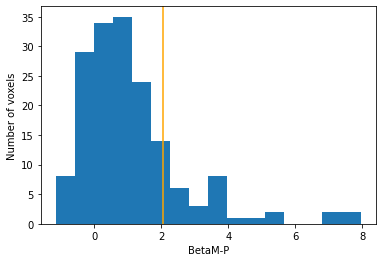

/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-LLGNM80_space-lgn_roi.nii.gz: 34 voxels
/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-LLGNP80_space-lgn_roi.nii.gz: 135 voxels
[135, 34, 263991]
[135, 34, 169]
beta_masked: (120, 120, 69)


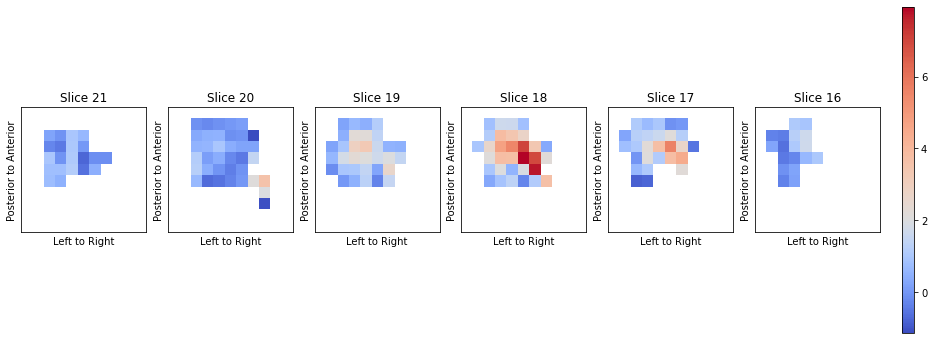

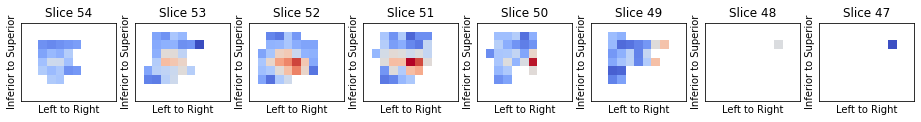

M
(34, 3)
ROI max and min coords [73 53 20] [67 49 17]
ROI extent (total voxel span and max/min distance from center): 
[7 5 4]
[2.6176 1.5882 1.9412]
[-3.3824 -2.4118 -1.0588]
ROI center in EPI and real-world coordinates: 
[70.3824 51.4118 18.0588]
[-18.1691   1.5686   4.328 ]
****
P
(135, 3)
ROI max and min coords [74 54 21] [67 47 16]
ROI extent (total voxel span and max/min distance from center): 
[8 8 6]
[2.7481 2.5852 2.2296]
[-4.2519 -4.4148 -2.7704]
ROI center in EPI and real-world coordinates: 
[71.2519 51.4148 18.7704]
[-19.6907   1.1376   5.4962]
****
/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-RLGN_space-lgn_roi.nii.gz
(82, 3)
ROI max and min coords [50 54 21] [46 50 16]
ROI extent (total voxel span and max/min distance from center): 
[5 5 6]
[2.0366 1.6098 2.9268]
[-1.9634 -2.3902 -2.0732]
ROI center in EPI and real-world coordinates: 
[47.9634 52.3902 18.0732]
[21.064   3.1637  4.9512]
****
****
****
Given the LGN mask 
/Us

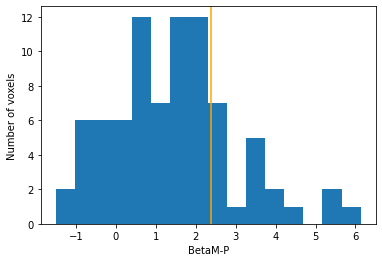

/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-RLGNM80_space-lgn_roi.nii.gz: 17 voxels
/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-RLGNP80_space-lgn_roi.nii.gz: 65 voxels
[65, 17, 263991]
[65, 17, 82]
beta_masked: (120, 120, 69)


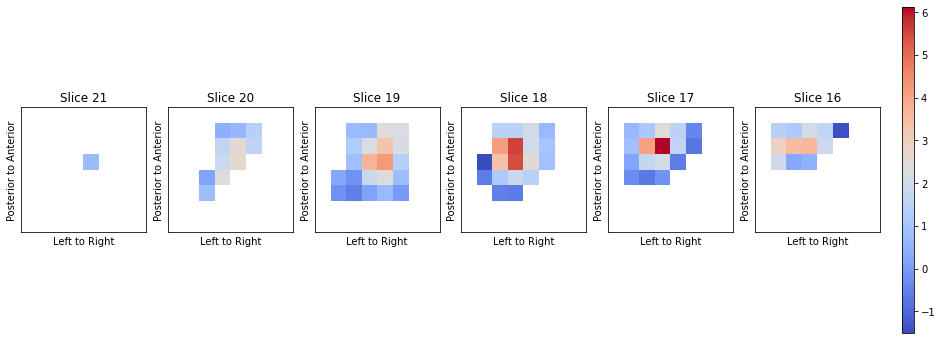

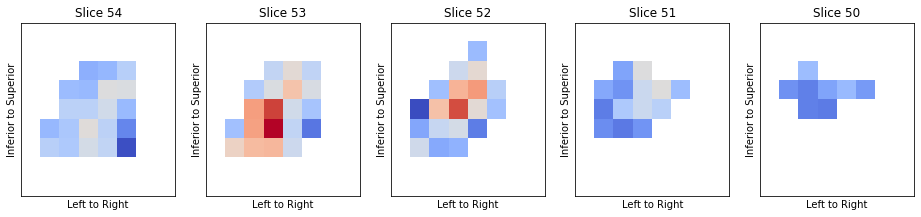

M
(17, 3)
ROI max and min coords [50 54 20] [47 51 16]
ROI extent (total voxel span and max/min distance from center): 
[4 4 5]
[2.     1.4118 2.0588]
[-1.     -1.5882 -1.9412]
ROI center in EPI and real-world coordinates: 
[48.     52.5882 17.9412]
[21.      3.5692  4.8562]
****
P
(65, 3)
ROI max and min coords [50 54 21] [46 50 16]
ROI extent (total voxel span and max/min distance from center): 
[5 5 6]
[2.0462 1.6615 2.8923]
[-1.9538 -2.3385 -2.1077]
ROI center in EPI and real-world coordinates: 
[47.9538 52.3385 18.1077]
[21.0808  3.0577  4.976 ]
****


In [173]:
for roi in final_big_rois:
    utils.roi_stats({roi:load_img(roi)}, lgn_ref_img)
    if 'desc-L' in roi:
        M_roi, P_roi, threshold = utils.assign_roi_percentile(roi, beta_MP_img, 80, lgn_ref_img, 'L')
    elif 'desc-R' in roi:
        M_roi, P_roi, threshold = utils.assign_roi_percentile(roi, beta_MP_img, 80, lgn_ref_img, 'R')
    else:
        print('Error - not sure which hemisphere roi is in')
    utils.roi_stats({'M':load_img(M_roi), 'P':load_img(P_roi)}, lgn_ref_img)

Big roi extends from [-12.25    -4.4012  -1.7506] to [-24.5      4.0087  10.7353]
Extent is [-12.25     8.4099  12.4859] and center is [-19.3846   1.2243   5.2612]
/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-LLGNM80_space-lgn_roi.nii.gz
[-18.1691   1.5686   4.328 ]
[0.5168 0.2901 0.5132]
/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-LLGNP80_space-lgn_roi.nii.gz
[-19.6907   1.1376   5.4962]
[0.3926 0.3414 0.4196]


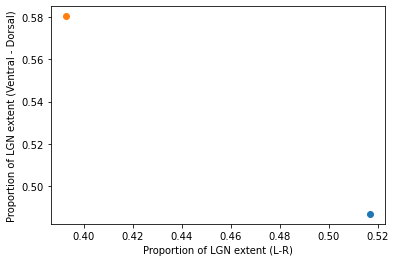

****
/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-LLGN_space-lgn_roi.nii.gz extends from [74 54 21] to [67 47 16] and is centered at:
[71.0769 51.4142 18.6272] (native) = (-19.384615384615387, 1.2242853606241049, 5.2611917260835845) (RAS)
(169, 3) (169,)


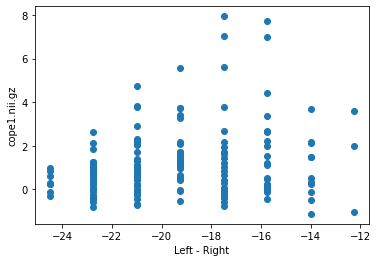

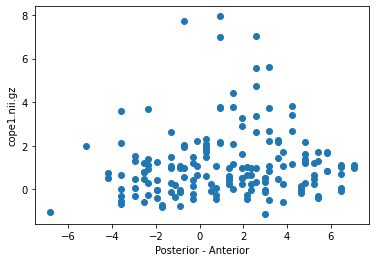

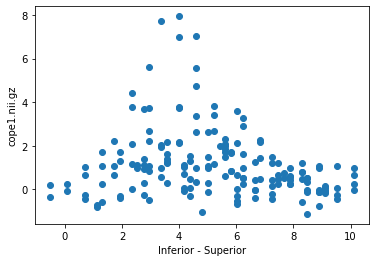

Big roi extends from [24.5     0.5163  0.088 ] to [17.5     4.0087 10.7353]
Extent is [-7.      3.4924 10.6473] and center is [21.064   3.1637  4.9512]
/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-RLGNM80_space-lgn_roi.nii.gz
[21.      3.5692  4.8562]
[0.5    0.1258 0.5522]
/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-RLGNP80_space-lgn_roi.nii.gz
[21.0808  3.0577  4.976 ]
[0.5115 0.2723 0.5409]


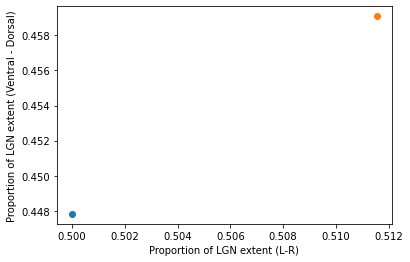

****
/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-RLGN_space-lgn_roi.nii.gz extends from [50 54 21] to [46 50 16] and is centered at:
[47.9634 52.3902 18.0732] (native) = (21.0640243902439, 3.1637470504132725, 4.951189477269246) (RAS)
(82, 3) (82,)


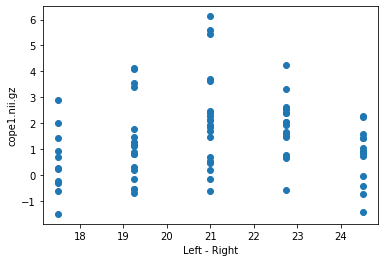

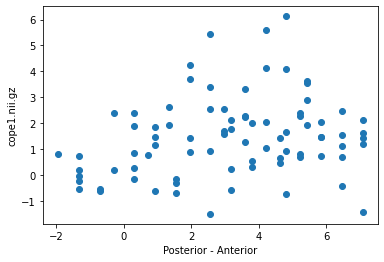

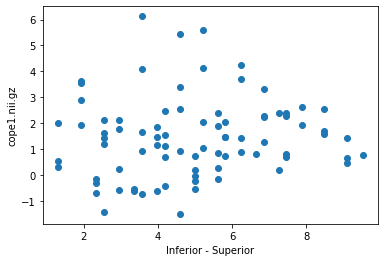

In [212]:
for roi in final_big_rois:
    parts = op.basename(roi).split('_')
    part = [x for x in parts if 'desc' in x]
    big_roi_stub = op.basename(roi).split('_')[-3]
    subdivision_rois = [f for f in rois if big_roi_stub in f and ('P' in f or 'M' in f)]
    utils.roi_centers(roi, subdivision_rois, load_img(lgn_ref_vol))
    utils.roi_map_scatter(roi, beta_MP, lgn_ref_img)

### Look at pRF results

In [209]:
#!ls -t {out_dir}

In [195]:
#lgn_rois_prf_space = [f"{out_dir}/sub-LL_ses-20210810_desc-LLGNprfsession_space-prf_roi.nii.gz"]

In [196]:
#lgn_rois_prf_space = preproc_layout.get(subject=sub, session=ses_lgn, space='prf', suffix='roi', return_type='file')

****
/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-LLGN_space-lgn_roi.nii.gz extends from [74 54 21] to [67 47 16] and is centered at:
[71.0769 51.4142 18.6272] (native) = (-19.384615384615387, 1.2242853606241049, 5.2611917260835845) (RAS)
(169, 3) (169,)


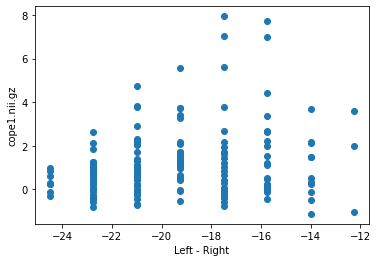

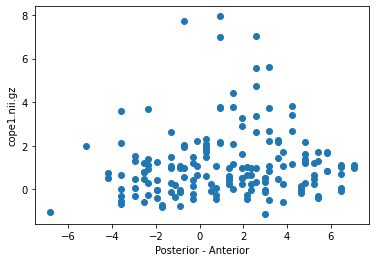

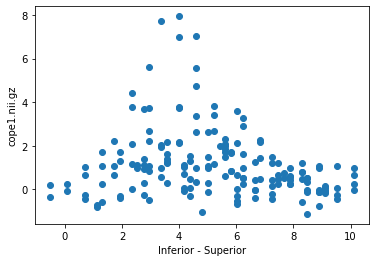

In [208]:
utils.roi_map_scatter(final_big_rois[0], beta_MP, lgn_ref_img)

In [230]:
lgn_rois_prf_space = [f"{out_dir}/sub-LL_ses-20210810_desc-LLGNprf3_space-prf_roi.nii.gz"]
#lgn_rois_prf_space = [f"{out_dir}/sub-LL_ses-20210810_desc-LLGNprfsession_space-prf_roi.nii.gz"]
#[f for f in lgn_rois_prf_space if 'desc-LLGN_' in f or 'desc-RLGN_' in f]
print('\n'.join(lgn_rois_prf_space), big_lgn_rois_prf_space, sep='\n')

/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210810_desc-LLGNprf3_space-prf_roi.nii.gz
['/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210810_desc-LLGNprf2_space-prf_roi.nii.gz']


In [231]:
!ls /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/prf/sub-LL/20210908-081328/

bar.pkl
info.txt
sub-LL_ses-20210810_desc-LLGNboundingbox_space-prf_roi.nii.gz
sub-LL_ses-20210810_desc-prfmask_space-func_map.nii.gz
sub-LL_ses-20210810_desc-prfrho_space-func_map.nii.gz
sub-LL_ses-20210810_desc-prfrho_space-func_thresh-prfrho-12.00_map.nii.gz
sub-LL_ses-20210810_desc-prfrsq_space-func_map.nii.gz
sub-LL_ses-20210810_desc-prfrsq_space-func_thresh-prfrho-12.00_map.nii.gz
sub-LL_ses-20210810_desc-prfsig_space-func_map.nii.gz
sub-LL_ses-20210810_desc-prftheta_space-func_map.nii.gz
sub-LL_ses-20210810_desc-prftheta_space-func_thresh-prfrho-12.00_map.nii.gz
sub-LL_ses-20210810_desc-prfxx_space-func_map.nii.gz
sub-LL_ses-20210810_desc-prfxx_space-func_thresh-prfrho-12.00_map.nii.gz
sub-LL_ses-20210810_desc-prfyy_space-func_map.nii.gz
sub-LL_ses-20210810_desc-prfyy_space-func_thresh-prfrho-12.00_map.nii.gz


In [117]:
beta_MP

'/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/nipype_LL_20211201_mp_20211206/fixedeffects/modelfit/datasink/stats_dir/_flameo0/stats/cope1.nii.gz'

In [118]:
final_big_rois[0]

'/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-LLGN_space-lgn_roi.nii.gz'

In [237]:
# prf eccentricity map
prf_ecc_map = "/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/prf/sub-LL/20210908-081328/sub-LL_ses-20210810_desc-prfrho_space-func_thresh-prfrho-12.00_map.nii.gz"
# prf_ecc_map = "/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/prf/sub-LL/20210908-081328/sub-LL_ses-20210810_desc-prfrho_space-func_thresh-prfrho-12.00_map.nii.gz"

In [238]:
# prf eccentricity map
prf_rsq_map = "/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/prf/sub-LL/20210908-081328/sub-LL_ses-20210810_desc-prfrsq_space-func_thresh-prfrho-12.00_map.nii.gz"
# prf_ecc_map = "/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/prf/sub-LL/20210908-081328/sub-LL_ses-20210810_desc-prfrho_space-func_thresh-prfrho-12.00_map.nii.gz"

0 /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210810_desc-LLGNprf3_space-prf_roi.nii.gz
0
(64, 3)
ROI max and min coords [79 58 10] [76 55  7]
ROI extent (total voxel span and max/min distance from center): 
[4 4 4]
[1.5 1.5 1.5]
[-1.5 -1.5 -1.5]
ROI center in EPI and real-world coordinates: 
[77.5 56.5  8.5]
[-23.625   -9.8796  -4.8558]
****
****
/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210810_desc-LLGNprf3_space-prf_roi.nii.gz extends from [79 58 10] to [76 55  7] and is centered at:
[77.5 56.5  8.5] (native) = (-23.624999999999986, -9.879614777863011, -4.855795316398144) (RAS)
(64, 3) (64,)


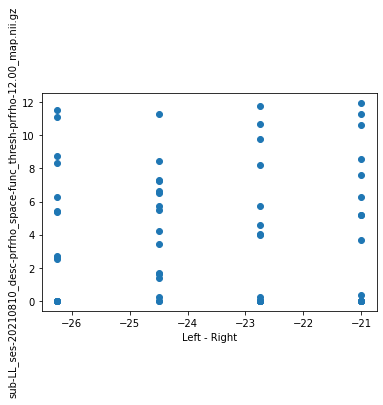

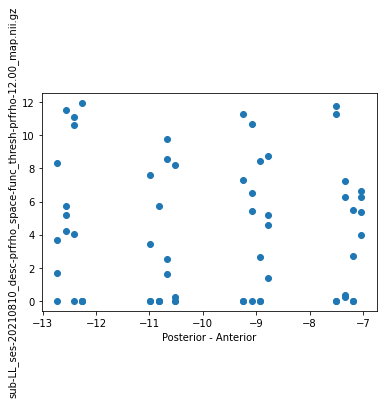

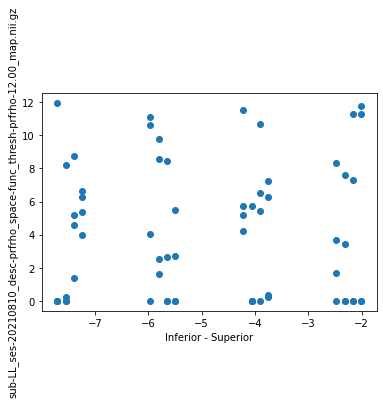

In [240]:
for i, x in zip(range(len(lgn_rois_prf_space)), lgn_rois_prf_space):
    print(i, x)
    utils.roi_stats({i: load_img(x)}, prf_ref_vol_img)
    utils.roi_map_scatter(x, prf_ecc_map, prf_ref_vol_img)
    #utils.roi_map_scatter(x, prf_rsq_map, prf_ref_vol_img)

In [ ]:
utils.roi_map_scatter()

In [ ]:
for roi in big_lgn_rois_prf_space:
    utils.assign_roi_percentile(roi, prf_ecc_map, 33, prf_ref_vol_img,
                                roi_below_suffix='lowecc', roi_above_suffix='highecc')

In [ ]:
for roi in big_lgn_rois_prf_space:
    print(roi)
    parts = op.basename(roi).split('_')
    part = [x for x in parts if 'desc' in x]
    if part:
        big_roi_stub = part[0]
        roi_list = preproc_layout.get(subject=sub, session=ses_lgn, space='prf', suffix='roi', return_type='file')
        subdivision_rois = [f for f in roi_list if big_roi_stub in f and ('ecc' in f)]
        #print(big_roi_stub, subdivision_rois)
        utils.roi_centers(roi, subdivision_rois, load_img(prf_ref_vol_img))

In [ ]:
preproc_layout.get(suffix='roi', space='prf')

## Coherence analysis to identify LGN voxels responding at flicker frequency

### Use the actual utils.py function

In [ ]:
hemi_bolds, hemi_masks, hemi_eventfiles, hemi_TR, hemi_confounds = utils.get_files(
    sub, ses_lgn, "hemi", raw_data_dir, out_dir,
    run=[1, 2])

### Define hemifield alternation time series etc

In [ ]:
cycle_duration = 27 # (should be 27s)
hemi_freq = (1.0/cycle_duration) # of hemifield alternation, in hertz
n_trs_func = 139 # Length, in TRs, on a functional scan
total_len = n_trs_func*hemi_TR # seconds
Fs = 1/hemi_TR # Sampling freq
trs_exc_beg = 6
trs_exc_end = 1
nfft = 61 #Number of time points to use in the window - 61 gives a band centered at .037037...
#nperseg = n_trs_func - trs_exc_beg - trs_exc_end

# frequency band of physiological relevance
f_lb = 0.02
f_ub = 0.15

# frequency band within which hemifield alternation related activity exists
f_lb_hemi = 0.035
f_ub_hemi = 0.038

print(hemi_freq)

t = np.arange(0.0, total_len, hemi_TR)
t_trim = np.arange((trs_exc_beg-1)*hemi_TR, (total_len - trs_exc_beg - trs_exc_end)+1, hemi_TR)
hemifield_alternation_sinusoid = np.sin(hemi_freq*2*np.pi*t)
hemi_alt_trim = hemifield_alternation_sinusoid[trs_exc_beg:(-1*trs_exc_end)]
print(t, hemifield_alternation_sinusoid.shape)

hemi_ts = ts.TimeSeries(data=hemifield_alternation_sinusoid,
                         sampling_interval=hemi_TR)
hemi_ts_trim = ts.TimeSeries(data=hemi_alt_trim,
                         sampling_interval=hemi_TR)

fig, ax = plt.subplots(1)
ax.set_xlim(0, 50)
ax.plot(t, hemifield_alternation_sinusoid)
#ax.plot(t_trim, hemi_alt_trim)
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Hemifield alternation")

In [ ]:
print(final_big_rois)

In [ ]:
roi = hemi_masks[0]

##### Run 1 of hemifield

In [ ]:
_, lgn_ts_run1 = utils.get_timeseries_from_file(hemi_bolds[0], roi, hemi_TR,
                                detrend=True, standardize='psc', high_pass=f_lb, low_pass=f_ub)

In [ ]:
_, (hemi_coh_by_voxel, hemi_phase_by_voxel) = utils.seed_coherence_timeseries(hemi_ts, lgn_ts_run1, f_ub, f_lb, dict(NFFT=nfft))

##### Run 2 of hemifield

##### No detrending or standardization

In [ ]:
lgn_masker, lgn_ts_run2 = utils.get_timeseries_from_file(hemi_bolds[1], roi, hemi_TR,
                                detrend=False, standardize=False, high_pass=f_lb, low_pass=f_ub)
_, (hemi_coh_by_voxel, hemi_phase_by_voxel) = utils.seed_coherence_timeseries(hemi_ts, lgn_ts_run2, f_ub, f_lb, dict(NFFT=nfft))

##### Detrended but no standardization

In [ ]:
lgn_masker, lgn_ts_run2 = utils.get_timeseries_from_file(hemi_bolds[1], roi, hemi_TR,
                                detrend=True, standardize=False, high_pass=f_lb, low_pass=f_ub)
_, (hemi_coh_by_voxel, hemi_phase_by_voxel) = utils.seed_coherence_timeseries(hemi_ts, lgn_ts_run2, f_ub, f_lb, dict(NFFT=nfft))

##### With detrending and conversion to percent signal change

In [ ]:
lgn_masker, lgn_ts_run2 = utils.get_timeseries_from_file(hemi_bolds[1], roi, hemi_TR,
                                detrend=True, standardize='psc', high_pass=f_lb, low_pass=f_ub)
_, (hemi_coh_by_voxel, hemi_phase_by_voxel) = utils.seed_coherence_timeseries(hemi_ts, lgn_ts_run2, f_ub, f_lb, dict(NFFT=nfft))

#### Average the runs for better SNR

In [ ]:
lgn_masker

In [ ]:
mean_bold_timeseries = utils.average_timeseries(hemi_bolds, lgn_masker)

In [ ]:
mean_bold_timeseries.shape

In [ ]:
trim_bold_nm = mean_bold_timeseries[trs_exc_beg:(-1*trs_exc_end),:] # note we are using the mean of the two runs
trim_bold_nm.shape

In [ ]:
mean_ts = ts.TimeSeries(data=trim_bold_nm.T, sampling_interval=hemi_TR)
hemi_analyzer, (hemi_coh_by_voxel, hemi_phase_by_voxel) = utils.seed_coherence_timeseries(hemi_ts_trim, mean_ts, f_ub, f_lb, dict(NFFT=nfft))

##### Run it again but this time with a narrow frequency range for just hemifield alternation

In [ ]:
hemi_analyzer, (hemi_coh_by_voxel, hemi_phase_by_voxel) = utils.seed_coherence_timeseries(hemi_ts_trim, mean_ts,
                                                                   f_ub_hemi, f_lb_hemi, dict(NFFT=nfft))

#### Write coherence values to Nifti file

In [ ]:
lgn_masker

In [ ]:
lgn_masker.get_params()

In [ ]:
len(hemi_coh_by_voxel)

In [ ]:
coherence_img = lgn_masker.inverse_transform(hemi_coh_by_voxel)
coherence_img.shape

In [ ]:
phase_img = lgn_masker.inverse_transform(hemi_phase_by_voxel)
phase_img.shape

In [ ]:
hemi_coh_fn = os.path.join(out_dir, f"sub-{sub}_ses-{ses}_task-hemi_desc-hemialtCoh_map.nii")
hemi_phase_fn = os.path.join(out_dir, f"sub-{sub}_ses-{ses}_task-hemi_desc-hemialtPhase_map.nii")

In [ ]:
coherence_img.to_filename(hemi_coh_fn)
phase_img.to_filename(hemi_phase_fn)

#### Look at cortical ROI coherence with hemifield alternations

In [ ]:
cortical_masker, cortical_ts_run2 = utils.get_timeseries_from_file(hemi_bolds[1], cortical_rois[0], hemi_TR,
                                detrend=False, standardize='zscore', high_pass=f_lb, low_pass=f_ub)
_, (hemi_coh_by_voxel_cortex, hemi_phase_by_voxel_cortex) = utils.seed_coherence_timeseries(hemi_ts, cortical_ts_run2, f_ub_hemi, f_lb_hemi, dict(NFFT=nfft))

#### Write coherence values to Nifti file

In [ ]:
coherence_img = cortical_masker.inverse_transform(hemi_coh_by_voxel_cortex)
coherence_img.shape

In [ ]:
print(cortex_coh_fn)

In [ ]:
coherence_img.to_filename(cortex_coh_fn)

#### SpectralAnalyzer - view and plot FFT, PSD, etc.

In [ ]:
def plot_spectra(S_original, voxid):
    fig01 = plt.figure()
    ax01 = fig01.add_subplot(1, 1, 1)
    if voxid is None:
        ax01.plot(S_original.psd[0],
                  S_original.psd[1],
                  label='PSD')
        ax01.plot(S_original.spectrum_fourier[0],
              np.abs(S_original.spectrum_fourier[1]),
              label='FFT')
#         ax01.plot(S_original.periodogram[0],
#               np.abs(S_original.periodogram[1]),
#               label='Periodogram')

#         ax01.plot(S_original.spectrum_multi_taper[0],
#               np.abs(S_original.spectrum_multi_taper[1]),
#               label='Multitaper')
        
    else:
        ax01.plot(S_original.psd[0],
                  S_original.psd[1][voxid],
                  label='PSD')
        ax01.plot(S_original.spectrum_fourier[0],
              np.abs(S_original.spectrum_fourier[1][voxid]),
              label='FFT')
#         ax01.plot(S_original.spectrum_multi_taper[0],
#               np.abs(S_original.spectrum_multi_taper[1][voxid]),
#               label='Multitaper')
    print(S_original.psd[0], S_original.psd[1], len(S_original.psd[1]), sep='\n')

    ax01.set_xlabel('Frequency (Hz)')
    ax01.set_ylabel('Power')

    ax01.legend()

In [ ]:
roi_mean_timeseries = ts.TimeSeries(np.mean(mean_ts.data, axis=0), sampling_interval=hemi_TR)

In [ ]:
roi_mean_timeseries.data.shape

In [ ]:
plot_spectra(
    nta.SpectralAnalyzer(hemi_ts_trim, method={#'this_method':'welch',
                                                        'NFFT':132,
                                                        'Fs':hemi_ts_trim.sampling_rate})
    , None)
plot_spectra(
    nta.SpectralAnalyzer(roi_mean_timeseries, method={#'this_method':'welch',
                                                        'NFFT':132,
                                                        'Fs':hemi_ts_trim.sampling_rate}), None)

### Mean across voxels of ROI timerseries but with nfft bins

In [ ]:
plot_spectra(
    nta.SpectralAnalyzer(hemi_ts_trim, method={#'this_method':'welch',
                                                        'NFFT':nfft,
                                                        'Fs':hemi_ts_trim.sampling_rate})
    , None)
plot_spectra(
    nta.SpectralAnalyzer(roi_mean_timeseries, method={#'this_method':'welch',
                                                        'NFFT':nfft,
                                                        'Fs':hemi_ts_trim.sampling_rate}), None)

### SeedCoherenceAnalyzer for connectivity

In [30]:
runs = [5, 9]
raw_conn_bolds = sorted([f for f in raw_layout.get(subject=sub, session=ses_conn, 
    task='conn', run=runs, suffix='bold', extension=['nii.gz'], return_type='file')])
conn_TR = raw_layout.get_metadata(raw_conn_bolds[0])['RepetitionTime']
conn_bolds = sorted([f for f in preproc_layout.get(subject=sub, session=ses_conn, 
    task='conn', run=runs, suffix='bold', extension=['nii.gz'], return_type='file')
            if fnmatch.fnmatch(f, '*desc-mcflirt_*')])
print('\n'.join(conn_bolds))

/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/ses-20210909/func/sub-LL_ses-20210909_task-conn_run-05_desc-mcflirt_bold.nii.gz
/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/ses-20210909/func/sub-LL_ses-20210909_task-conn_run-09_desc-mcflirt_bold.nii.gz


In [31]:
f_lb = 0.025
f_ub = 0.15

In [32]:
print("\n".join(big_rois))

/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-LLGN_space-lgn_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-RLGN_space-lgn_roi.nii.gz


In [33]:
conn_lgn_rois_sub = [f for f in lgn_rois if fnmatch.fnmatch(f, '*desc-[LR]LGN[MP]*')]
logger.debug(conn_lgn_rois_sub)

2021-12-16 22:10:09,877 - __main__ - DEBUG - ['/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-LLGNM80_space-lgn_roi.nii.gz', '/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-LLGNP80_space-lgn_roi.nii.gz', '/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-RLGNM80_space-lgn_roi.nii.gz', '/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-RLGNP80_space-lgn_roi.nii.gz']


In [34]:
cortical_rois
v1s = [f for f in cortical_rois if 'v1_' in f]

2021-12-16 23:08:39,732 - __main__ - DEBUG - ['sub-LL', 'ses-20211201', 'desc-LLGNM80', 'space-lgn', 'roi.nii.gz']
2021-12-16 23:08:39,733 - __main__ - DEBUG - Analyzing Run 0: /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/ses-20210909/func/sub-LL_ses-20210909_task-conn_run-05_desc-mcflirt_bold.nii.gz
2021-12-16 23:08:39,734 - __main__ - DEBUG - ['sub-LL', 'ses-20210909', 'task-conn', 'run-05', 'desc-mcflirt', 'bold.nii.gz']
2021-12-16 23:08:39,737 - __main__ - DEBUG - coh: /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210909_task-conn_run-05_desc-LLGNM80+Lips0_space-lgn_coherence_map.nii
phase: /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210909_task-conn_run-05_desc-LLGNM80+Lips0_space-lgn_phase_map.nii

2021-12-16 23:08:39,739 - utils - DEBUG - bold: /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/ses-20210909/func/sub-LL_ses-20210909_task-conn_run-05_desc-mcflirt_bold.ni

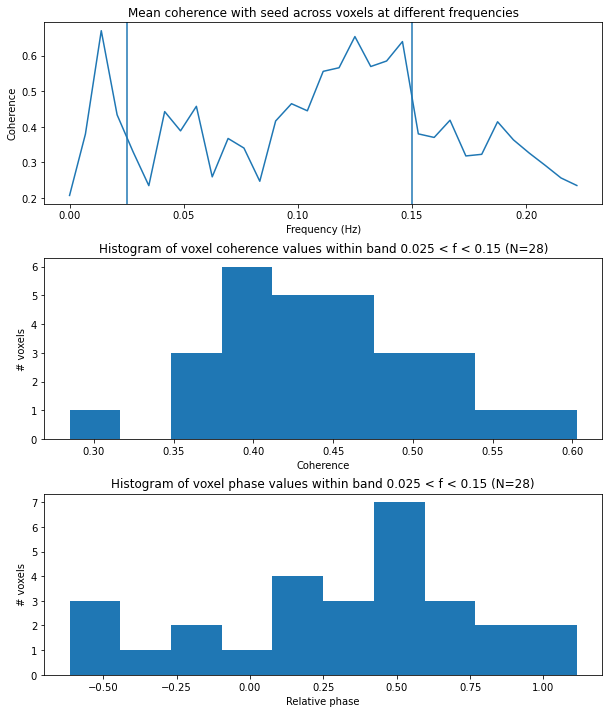

2021-12-16 23:08:57,797 - utils - DEBUG - seed_ts: (132,)
target_ts: (28, 132)
(28, 33)
(28, 33),(33,), (), (28,)
2021-12-16 23:08:57,798 - utils - DEBUG - seed_coherence_analysis() about to return...
2021-12-16 23:08:58,026 - __main__ - DEBUG - Analyzing Run 1: /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/ses-20210909/func/sub-LL_ses-20210909_task-conn_run-09_desc-mcflirt_bold.nii.gz
2021-12-16 23:08:58,028 - __main__ - DEBUG - ['sub-LL', 'ses-20210909', 'task-conn', 'run-09', 'desc-mcflirt', 'bold.nii.gz']
2021-12-16 23:08:58,030 - __main__ - DEBUG - coh: /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210909_task-conn_run-09_desc-LLGNM80+Lips0_space-lgn_coherence_map.nii
phase: /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210909_task-conn_run-09_desc-LLGNM80+Lips0_space-lgn_phase_map.nii

2021-12-16 23:08:58,033 - utils - DEBUG - bold: /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/stre

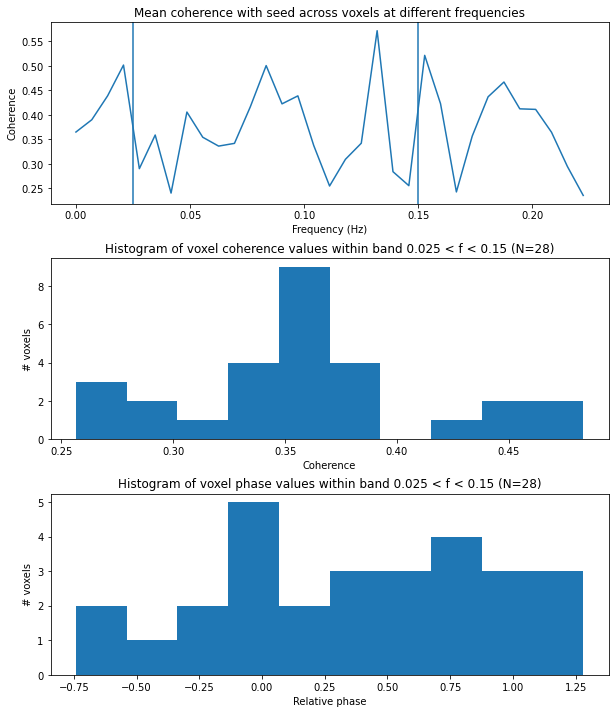

2021-12-16 23:09:11,779 - utils - DEBUG - seed_ts: (132,)
target_ts: (28, 132)
(28, 33)
(28, 33),(33,), (), (28,)
2021-12-16 23:09:11,783 - utils - DEBUG - seed_coherence_analysis() about to return...
2021-12-16 23:09:11,981 - __main__ - DEBUG - ['sub-LL', 'ses-20211201', 'desc-LLGNM80', 'space-lgn', 'roi.nii.gz']
2021-12-16 23:09:11,985 - __main__ - DEBUG - Analyzing Run 0: /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/ses-20210909/func/sub-LL_ses-20210909_task-conn_run-05_desc-mcflirt_bold.nii.gz
2021-12-16 23:09:11,987 - __main__ - DEBUG - ['sub-LL', 'ses-20210909', 'task-conn', 'run-05', 'desc-mcflirt', 'bold.nii.gz']
2021-12-16 23:09:11,989 - __main__ - DEBUG - coh: /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210909_task-conn_run-05_desc-LLGNM80+Lips1_space-lgn_coherence_map.nii
phase: /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210909_task-conn_run-05_desc-LLGNM80+Lips1_space-lgn_phase

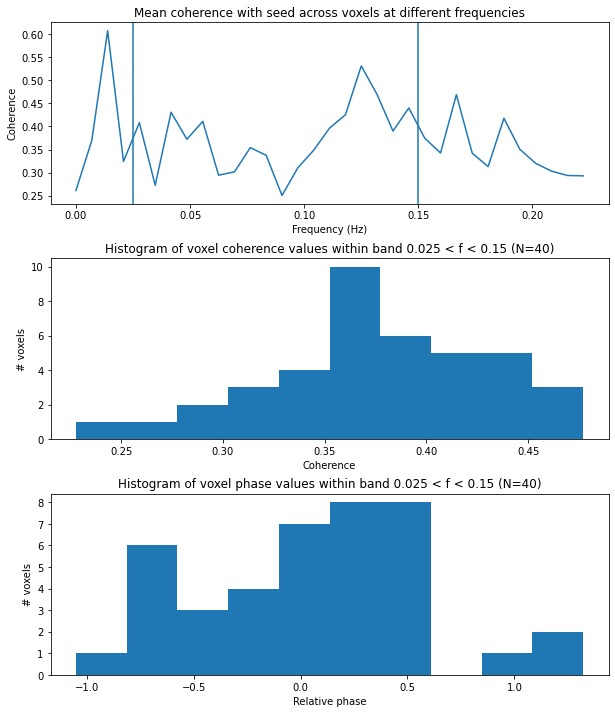

2021-12-16 23:09:25,882 - utils - DEBUG - seed_ts: (132,)
target_ts: (40, 132)
(40, 33)
(40, 33),(33,), (), (40,)
2021-12-16 23:09:25,883 - utils - DEBUG - seed_coherence_analysis() about to return...
2021-12-16 23:09:25,997 - __main__ - DEBUG - Analyzing Run 1: /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/ses-20210909/func/sub-LL_ses-20210909_task-conn_run-09_desc-mcflirt_bold.nii.gz
2021-12-16 23:09:26,000 - __main__ - DEBUG - ['sub-LL', 'ses-20210909', 'task-conn', 'run-09', 'desc-mcflirt', 'bold.nii.gz']
2021-12-16 23:09:26,007 - __main__ - DEBUG - coh: /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210909_task-conn_run-09_desc-LLGNM80+Lips1_space-lgn_coherence_map.nii
phase: /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210909_task-conn_run-09_desc-LLGNM80+Lips1_space-lgn_phase_map.nii

2021-12-16 23:09:26,009 - utils - DEBUG - bold: /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/stre

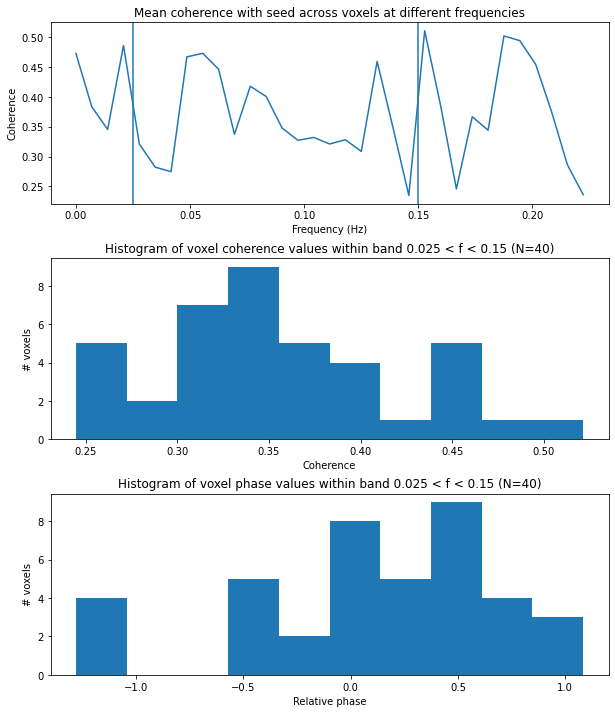

2021-12-16 23:09:39,224 - utils - DEBUG - seed_ts: (132,)
target_ts: (40, 132)
(40, 33)
(40, 33),(33,), (), (40,)
2021-12-16 23:09:39,226 - utils - DEBUG - seed_coherence_analysis() about to return...
2021-12-16 23:09:39,329 - __main__ - DEBUG - ['sub-LL', 'ses-20211201', 'desc-LLGNM80', 'space-lgn', 'roi.nii.gz']
2021-12-16 23:09:39,333 - __main__ - DEBUG - Analyzing Run 0: /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/ses-20210909/func/sub-LL_ses-20210909_task-conn_run-05_desc-mcflirt_bold.nii.gz
2021-12-16 23:09:39,336 - __main__ - DEBUG - ['sub-LL', 'ses-20210909', 'task-conn', 'run-05', 'desc-mcflirt', 'bold.nii.gz']
2021-12-16 23:09:39,340 - __main__ - DEBUG - coh: /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210909_task-conn_run-05_desc-LLGNM80+Llo1_space-lgn_coherence_map.nii
phase: /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210909_task-conn_run-05_desc-LLGNM80+Llo1_space-lgn_phase_m

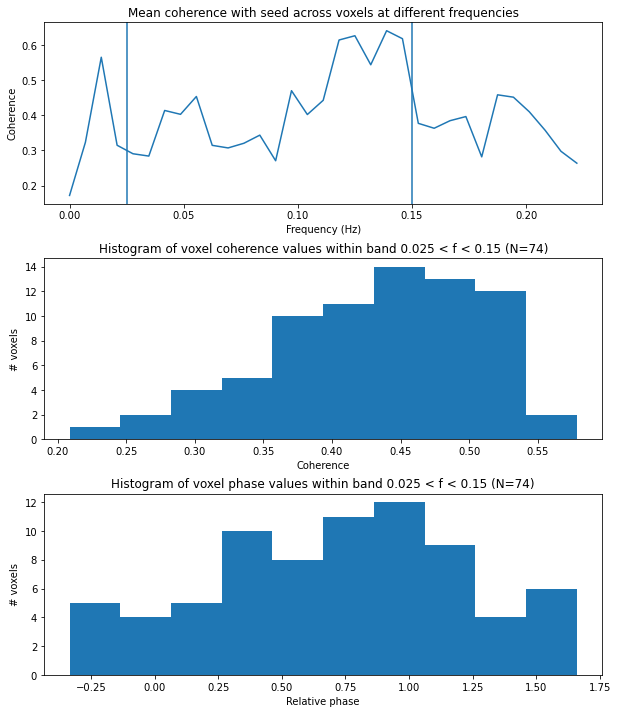

2021-12-16 23:09:53,382 - utils - DEBUG - seed_ts: (132,)
target_ts: (74, 132)
(74, 33)
(74, 33),(33,), (), (74,)
2021-12-16 23:09:53,383 - utils - DEBUG - seed_coherence_analysis() about to return...
2021-12-16 23:09:53,500 - __main__ - DEBUG - Analyzing Run 1: /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/ses-20210909/func/sub-LL_ses-20210909_task-conn_run-09_desc-mcflirt_bold.nii.gz
2021-12-16 23:09:53,504 - __main__ - DEBUG - ['sub-LL', 'ses-20210909', 'task-conn', 'run-09', 'desc-mcflirt', 'bold.nii.gz']
2021-12-16 23:09:53,506 - __main__ - DEBUG - coh: /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210909_task-conn_run-09_desc-LLGNM80+Llo1_space-lgn_coherence_map.nii
phase: /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210909_task-conn_run-09_desc-LLGNM80+Llo1_space-lgn_phase_map.nii

2021-12-16 23:09:53,508 - utils - DEBUG - bold: /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/stream

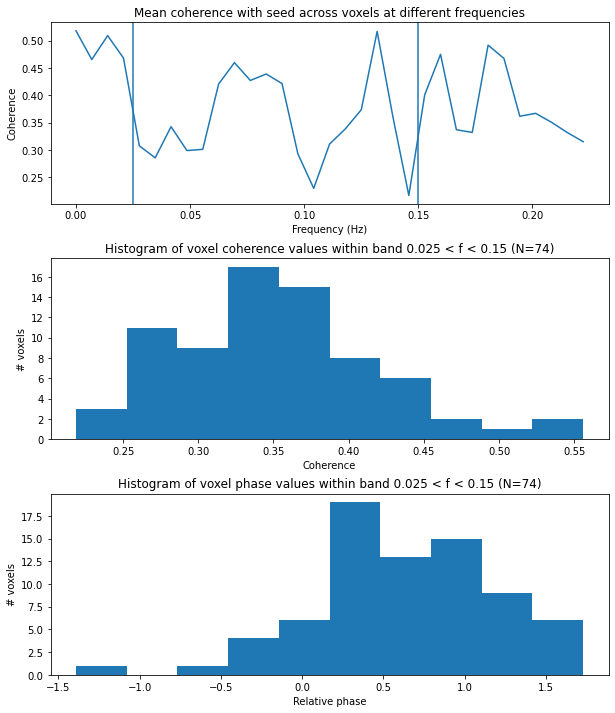

2021-12-16 23:10:06,559 - utils - DEBUG - seed_ts: (132,)
target_ts: (74, 132)
(74, 33)
(74, 33),(33,), (), (74,)
2021-12-16 23:10:06,562 - utils - DEBUG - seed_coherence_analysis() about to return...
2021-12-16 23:10:06,776 - __main__ - DEBUG - ['sub-LL', 'ses-20211201', 'desc-LLGNM80', 'space-lgn', 'roi.nii.gz']
2021-12-16 23:10:06,779 - __main__ - DEBUG - Analyzing Run 0: /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/ses-20210909/func/sub-LL_ses-20210909_task-conn_run-05_desc-mcflirt_bold.nii.gz
2021-12-16 23:10:06,781 - __main__ - DEBUG - ['sub-LL', 'ses-20210909', 'task-conn', 'run-05', 'desc-mcflirt', 'bold.nii.gz']
2021-12-16 23:10:06,784 - __main__ - DEBUG - coh: /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210909_task-conn_run-05_desc-LLGNM80+Llo2_space-lgn_coherence_map.nii
phase: /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210909_task-conn_run-05_desc-LLGNM80+Llo2_space-lgn_phase_m

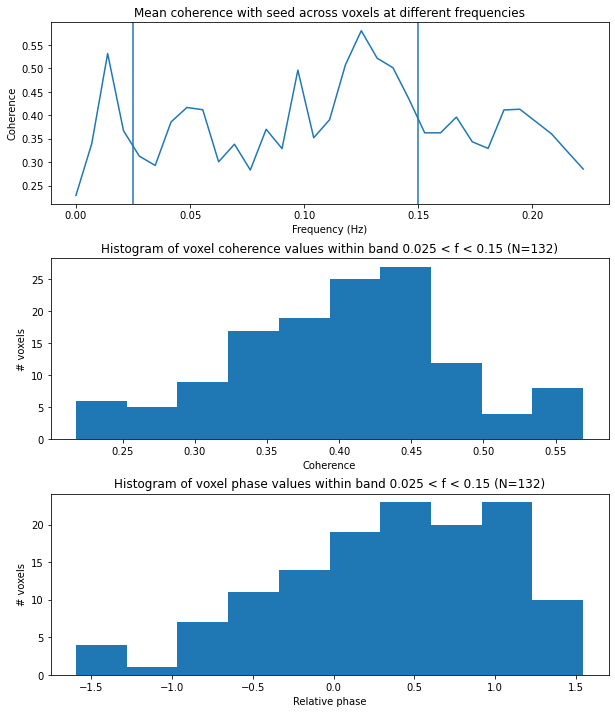

2021-12-16 23:10:19,004 - utils - DEBUG - seed_ts: (132,)
target_ts: (132, 132)
(132, 33)
(132, 33),(33,), (), (132,)
2021-12-16 23:10:19,006 - utils - DEBUG - seed_coherence_analysis() about to return...
2021-12-16 23:10:19,241 - __main__ - DEBUG - Analyzing Run 1: /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/ses-20210909/func/sub-LL_ses-20210909_task-conn_run-09_desc-mcflirt_bold.nii.gz
2021-12-16 23:10:19,243 - __main__ - DEBUG - ['sub-LL', 'ses-20210909', 'task-conn', 'run-09', 'desc-mcflirt', 'bold.nii.gz']
2021-12-16 23:10:19,247 - __main__ - DEBUG - coh: /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210909_task-conn_run-09_desc-LLGNM80+Llo2_space-lgn_coherence_map.nii
phase: /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210909_task-conn_run-09_desc-LLGNM80+Llo2_space-lgn_phase_map.nii

2021-12-16 23:10:19,251 - utils - DEBUG - bold: /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/st

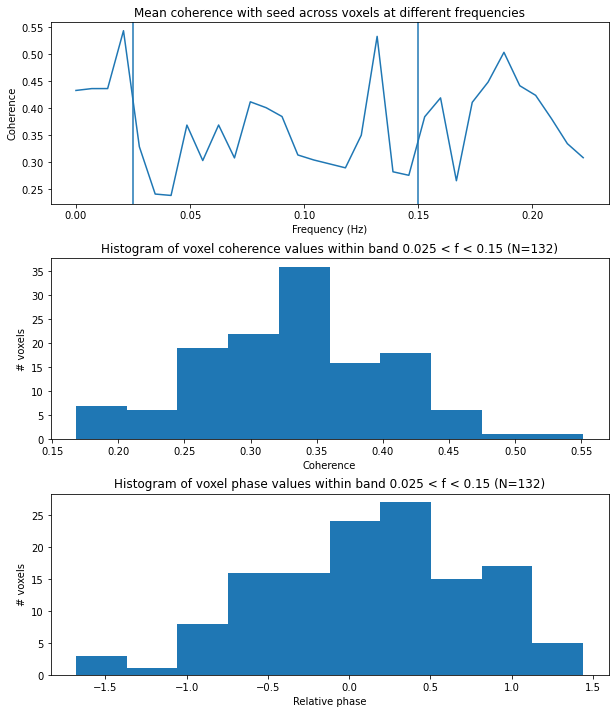

2021-12-16 23:10:32,236 - utils - DEBUG - seed_ts: (132,)
target_ts: (132, 132)
(132, 33)
(132, 33),(33,), (), (132,)
2021-12-16 23:10:32,238 - utils - DEBUG - seed_coherence_analysis() about to return...
2021-12-16 23:10:32,438 - __main__ - DEBUG - ['sub-LL', 'ses-20211201', 'desc-LLGNM80', 'space-lgn', 'roi.nii.gz']
2021-12-16 23:10:32,440 - __main__ - DEBUG - Analyzing Run 0: /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/ses-20210909/func/sub-LL_ses-20210909_task-conn_run-05_desc-mcflirt_bold.nii.gz
2021-12-16 23:10:32,443 - __main__ - DEBUG - ['sub-LL', 'ses-20210909', 'task-conn', 'run-05', 'desc-mcflirt', 'bold.nii.gz']
2021-12-16 23:10:32,447 - __main__ - DEBUG - coh: /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210909_task-conn_run-05_desc-LLGNM80+Lto1_space-lgn_coherence_map.nii
phase: /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210909_task-conn_run-05_desc-LLGNM80+Lto1_space-lgn_pha

In [ ]:
cohs = []
phases = []
for roi in conn_lgn_rois_sub:
    for cortical_roi in cortical_rois:
        bn = op.basename(roi)
        parts = bn.split('_')
        logger.debug(f"{parts}")
        spacepart = [p for p in parts if 'space-' in p][0]
        roi_desc = [p for p in parts if 'desc-' in p][0]
        cortical_roi_desc = [p for p in cortical_roi.split('_') if 'desc-' in p][0].split('-')[-1]
        for i, bold in enumerate(conn_bolds):
            logger.debug(f"Analyzing Run {i}: {bold}")
            bbn = op.basename(bold)
            logger.debug(bbn.split('_'))
            runpart = [p for p in bbn.split('_') if 'run-' in p][0]
            conn_coh_fn = os.path.join(out_dir, f"sub-{sub}_ses-{ses_conn}_task-conn_{runpart}_{roi_desc}+{cortical_roi_desc}_{spacepart}_coherence_map.nii")
            conn_phase_fn = os.path.join(out_dir, f"sub-{sub}_ses-{ses_conn}_task-conn_{runpart}_{roi_desc}+{cortical_roi_desc}_{spacepart}_phase_map.nii")
            logger.debug(f"coh: {conn_coh_fn}\nphase: {conn_phase_fn}\n")
            #below: wholebrain mask with mean of seed roi
            # 2/3/21: cahnged to use cortical roi instead of wholebrain
            a, target_masker, coherence_by_voxel, phase_by_voxel = utils.seed_coherence_analysis(bold, cortical_roi, roi,
                              conn_TR, f_ub, f_lb, mean_seed=True, method=dict(NFFT=64))
            coherence_map_img = target_masker.inverse_transform(coherence_by_voxel)
            phase_img = target_masker.inverse_transform(phase_by_voxel)
            coherence_map_img.to_filename(conn_coh_fn)
            phase_img.to_filename(conn_phase_fn)
            cohs.append(a.coherence)
            phases.append(a.relative_phases)    

In [36]:
len(cohs)

16

In [37]:
for roi in conn_lgn_rois_sub:
    seed_roi_desc = utils.get_bids_part(roi, 'desc-')
    logger.debug(f"seed: {roi}")
    for cortical_roi in v1s:
        logger.debug(f"target: {cortical_roi}")
        cortical_roi_desc = utils.get_bids_part(cortical_roi, 'desc-').split('-')[-1]
        phase_maps = sorted(glob.glob(f"{out_dir}/sub-{sub}_ses-{ses_conn}_*{seed_roi_desc}+{cortical_roi_desc}*phase_map.nii"))
        logger.debug(f"Phase maps ({len(phase_maps)}): {phase_maps}")
        if len(phase_maps)==2:
            phase_diff_img = math_img(f"img1 - img2", img1=phase_maps[0], img2=phase_maps[1])
            phase_diff_path = f"{out_dir}/sub-{sub}_ses-{ses_conn}_task-conn_{seed_roi_desc}+{cortical_roi_desc}_phasediff_map.nii"
            phase_diff_img.to_filename(phase_diff_path)
            logger.debug(f"Phase diff written to {phase_diff_path}")
        else:
            logger.debug("# of phase images is not exactly 2, not doing phase diffs!")

2021-12-16 22:14:14,159 - __main__ - DEBUG - seed: /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20211201_desc-LLGNM80_space-lgn_roi.nii.gz
2021-12-16 22:14:14,163 - __main__ - DEBUG - target: /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_desc-Lv1_space-conn_roi.nii.gz
2021-12-16 22:14:14,197 - __main__ - DEBUG - Phase maps (2): ['/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210909_task-conn_run-05_desc-LLGNM80+Lv1_space-lgn_phase_map.nii', '/Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210909_task-conn_run-09_desc-LLGNM80+Lv1_space-lgn_phase_map.nii']
2021-12-16 22:14:14,620 - __main__ - DEBUG - Phase diff written to /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/streams/sub-LL/sub-LL_ses-20210909_task-conn_desc-LLGNM80+Lv1_phasediff_map.nii
2021-12-16 22:14:14,623 - __main__ - DEBUG - target: /Users/smerdis/data/LGN/BIDS/LL_combined/derivatives/st